In [50]:
# defining functions used below
import numpy as np
import matplotlib.gridspec as gs
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import pandas as pd
import scipy.stats as scistats
from scipy.cluster import hierarchy
from hmmlearn.hmm import GaussianHMM
import scipy.linalg as scilin
from scipy.sparse import csr_matrix
from cooltools.expected import diagsum
from cooltools.saddle import make_cis_obsexp_fetcher
import cooler
import tables
import itertools as it
import warnings
import os

redmap = clr.LinearSegmentedColormap.from_list('redmap', ['White', 'Red'], N = 256)

def readchromlens(chromlenfile):
    '''
    readchromlens(chromlenfile)

    reads chromosome sizes of all standard chromosomes (i.e. 1 - X and Y, no random)
    from the given tab separated file which is assumed to have the following format:

    chrname     chrsize

    :param chromlenfile:    name of the tab-separated file holding chromosome sizes

    :return:                dictionary with chrname as keys and chrsize as values
    '''

    with open(chromlenfile, 'r') as chrfile:
        chromlens = {}
        for line in chrfile:
            chr, size = line.rstrip().split('\t')

            if not len(chr.split('_')) > 1:
                chromlens[chr] = int(size)

    return chromlens


def toString(s):
    """
    This takes care of python2/3 differences
    """
    if isinstance(s, str):
        return s

    if isinstance(s, bytes):  # or isinstance(s, np.bytes_):
        if sys.version_info[0] == 2:
            return str(s)
        return s.decode('ascii')

    if isinstance(s, list):
        return [toString(x) for x in s]

    if isinstance(s, np.ndarray):
        return s.astype(str)

    return s


def loadH5(filename, includechroms=None, csr=True, returnintervals = False, dtype = int):
    '''
    loadH5(filename, includechroms=None, csr=True, returnintervals = False)

    loads an *.h5 hic matrix as created by hicexplorer

    :param filename:        name of the *.h5 file containing the matrix
    :param includechroms:   list of chromosomes to include in the returned objects
                            if not given all chromosomes in the *.h5 file are included
    :param csr:             if True returns a csr_matrix object else a full numpy.array
    :param returnintervals: if True also returns the intervals read

    :return:                csr_matrix containing the data in the matrix
    '''
    with tables.open_file(filename) as f:
        parts = {}
        try:
            for matrix_part in ('data', 'indices', 'indptr', 'shape'):
                parts[matrix_part] = getattr(f.root.matrix, matrix_part).read()
        except Exception:
            logging.info('No h5 file. Please check parameters concerning the file type!')
            exit(1)

        matrix = csr_matrix(tuple([parts['data'], parts['indices'], parts['indptr']]),
                            shape=parts['shape'], dtype=dtype)

        intervals = {}
        for interval_part in ('chr_list', 'start_list', 'end_list', 'extra_list'):
            if toString(interval_part) == toString('chr_list'):
                chrom_list = getattr(f.root.intervals, interval_part).read()
                intervals[interval_part] = toString(chrom_list)
            else:
                intervals[interval_part] = getattr(f.root.intervals, interval_part).read()

        cut_intervals = list(
            zip(intervals['chr_list'], intervals['start_list'], intervals['end_list'], intervals['extra_list']))

        assert len(cut_intervals) == matrix.shape[0], \
            "Error loading matrix. Length of bin intervals ({}) is different than the " \
            "size of the matrix ({})".format(len(cut_intervals), matrix.shape[0])

        # compute index array and chromosome list
        inds, chr_list, chroms = [], [], set()
        for i, (chr, start, end, extra) in enumerate(cut_intervals):
            if chr not in chroms:
                chroms.add(chr)
                inds.append(i)
                chr_list.append(chr)

        # if includechroms is given we filter the output for the chromosomes listed
        # and recompute indices of chromosome boundaries in the resulting matrix
        if includechroms:
            includechroms = set(includechroms)
            filterinds, filterchrs = [], []
            for i, chr in zip(range(len(inds)), chr_list):
                if chr in includechroms:
                    filterinds.append([inds[i], inds[i + 1] if i + 1 != len(inds) else matrix.shape[0]])
                    filterchrs.append(chr)

            matrixinds = np.zeros(shape=matrix.shape[0], dtype=bool)
            ncuts, tmpe = [], 0
            for s, e in filterinds:
                matrixinds[s: e] = True

                if s == tmpe:
                    ncuts.append(s)
                    tmpe = e

                else:
                    ncuts.append(tmpe)
                    tmpe = e - s + tmpe

            if csr:
                matrix = matrix[matrixinds, :][:, matrixinds]

            else:
                matrix = matrix.toarray()
                xi, yi = np.triu_indices(matrix.shape[0], k=1)
                matrix[yi, xi] = matrix[xi, yi]

            inds = ncuts

            chr_list = filterchrs

    if not includechroms and not csr:
        x = matrix.toarray()
        xi, yi = np.triu_indices(x.shape[0], k=1)
        x[yi, xi] = x[xi, yi]
        matrix = x

    if returnintervals:
        return matrix, np.array(inds), np.array(chr_list), intervals

    else:
        return matrix, np.array(inds), np.array(chr_list)


def loadCooler(cooleruri, applyNorm = False, norm = 'weight', includeChroms = None, nans_to_zero = False):
    '''
    loads a cooler into a csr matrix
    taken from HiCMatrix cool.py see also
    https://github.com/deeptools/HiCMatrix/blob/master/hicmatrix/lib/cool.py

    :param cooleruri:       uri to a given cooler
    :param applyNorm:       if True then the 'norm' is applied to the datapoints in the matrix
    :param norm:            normalization weights to apply if applyNorm is set True
    :param includeChroms:   list of chromosomes to load, if given only the specified chromosomes will be loaded from the cooler

    :return:            data in cooler as scipy.sparse.csr_matrix
    '''
    cooler_file = cooler.Cooler(cooleruri)
    matrix = cooler_file.matrix(balance = norm if applyNorm else False)[:]

    chroms = cooler_file.chromnames
    inds = set()
    for chrom in chroms:
        for binidx in cooler_file.extent(chrom):
            inds.add(binidx)

    inds = sorted(list(inds))

    if includeChroms:
        includechroms = set(includeChroms)
        filterinds, filterchroms = [], []
        for i, chr in zip(range(len(inds)), chroms):
            if chr in includechroms:
                filterinds.append([inds[i], inds[i + 1] if i + 1 != len(inds) else matrix.shape[0]])
                filterchroms.append(chr)

        matrixinds = np.zeros(shape=matrix.shape[0], dtype=bool)
        ncuts, tmpe = [], 0
        for s, e in filterinds:
            matrixinds[s: e] = True

            if s == tmpe:
                ncuts.append(s)
                tmpe = e

            else:
                ncuts.append(tmpe)
                tmpe = e - s + tmpe

        matrix = matrix[matrixinds, :][:, matrixinds]

        inds = ncuts

        chroms = filterchroms

        if nans_to_zero:
            matrix[np.isnan(matrix)] = 0

    return matrix, np.array(inds), np.array(chroms)


def readGeneTrack(bedfile, chr, chrbins, resolution):
    '''
    reads in a genetrack file in BED format and returns a numpy.array
    with 1 if a gene is in a given bin or 0 else. This function assumes
    that the bedfile is sorted by chromosome and startposition

    :param bedfile:     BED file holding gene annotation for the given genome
    :param chr:         chromosome to retrieve the genetrack for
    :param chrbins:     number of bins the chromosome is divided in
    :param resolution:  size of the bins used to construct the contact matrix

    :return:            numpy.array holding genetrack information
    '''
    # initializing return array
    genetrack = np.zeros(shape = chrbins, dtype = int)

    # reading geneTrack
    with open(bedfile, 'r') as bed:
        brake = False
        for gene in bed:
            c, start, end, name = gene.rstrip().split('\t')[:4]

            # if we are not on the right chromosome
            if not c == chr:
                # if we already parsed the desired chromosome
                if brake:
                    # we break out of the loop
                    break

                # if we not yet parsed the desired chromosome
                else:
                    # we continue
                    continue

            else:
                # computing the bins to set value 1 to
                start, end = [int(pos) for pos in [start, end]]
                i1, i2 = start//resolution, end//resolution + 1
                genetrack[i1: i2] = 1

                if not brake:
                    brake = True

    return genetrack


def correlateEigenvectorWithGeneTrack(eigenvector, genetrack):
    '''
    computed the correlation between an eigenvector of a given chromosome and
    its gene track. If the correlation is negative the sign of the eigenvector values
    is flipped.

    :param eigenvector: first eigenvector of the correlation matrix
    :param genetrack:   numpy.array holding a 1 if there is a gene in the bin and 0 otherwise

    :return:            eigenvector with flipped signs if correlation between values and genetrack
                        is negative otherwise same as given
    '''
    correlation, pval = scistats.pearsonr(eigenvector, genetrack)

    return eigenvector if correlation >= 0 else np.negative(eigenvector)


def compartmentalize(eomat, gtrack, resolution, cmap = 'coolwarm', vmin = None, vmax = None,
                     figsize = (6, 9), clusters = None, clstclrs = None, xtickpad = 50):
    '''
    compartmentalize(eomat, resolution, cmap = 'coolwarm', vmin = None, vmax = None,
                     figsize = (6, 9), clusters = None, clstclrs = None)

    computes the principal components and creates a barplot of the first principle component

    :param eomat:       E/O matrix of a given contact matrix
    :param gtrack:      genetrack of the current chromosome as returned by readGeneTrack
    :param resolution:  binsize used to count contacts in kb
    :param cmap:        colomap to use for plotting the correlation matrix (default = coolwarm)
    :param vmin:        minimum value for colormap (if None vmin = 0)
    :param vmax:        maximum value for colormap (if None vmax = max(corrmat)
    :param figsize:     size of the figure created (width, height)
    :param clusters:    if given, a third plot is generated illustrating the cluster annotation per plotted bin
    :param clstclrs:    dictionary mapping clusterlabels to its color
    :param xtickpad:    padding of xticklabels

    :return:            matplotlib.figure, matplotlib.Axes objects for barplot and heatmap
    '''

    # computing pearson correlation matrix
    # ignoring divide by 0 warning
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        pcorrmat = np.corrcoef(eomat)

    # making sure all values are well defined
    pcorrmat[np.isnan(pcorrmat)] = 0.
    pcorrmat[np.isinf(pcorrmat)] = 0.

    # computing covariance matrix
    covmat = np.cov(pcorrmat)

    # making sure all values are well defined
    covmat[np.isnan(covmat)] = 0.
    covmat[np.isinf(covmat)] = 0.

    # computing eigenvalues and eigenvectors
    lambdas, eigvs = scilin.eigh(covmat)
    
    # correlating first eigenvector with genetrack
    # to flip signs if correlation is negative
    eigv1 = correlateEigenvectorWithGeneTrack(eigvs[:, -1], gtrack)

    # plotting
    fig = plt.figure(figsize = figsize)

    if not np.any(clusters):
        grid = gs.GridSpec(2, 1, height_ratios = [5,1])

    else:
        grid = gs.GridSpec(3, 1, height_ratios = [5,1,1])

    # adding subplots into grid
    heatax = fig.add_subplot(grid[0])
    barax = fig.add_subplot(grid[1], sharex = heatax)

    if np.any(clusters):
        clstax = fig.add_subplot(grid[2], sharex = heatax)

    # plotting correlation matrix
    heatax, im = plotmatrix(covmat, cmap = cmap, vmin = vmin,
                            vmax = vmax, ax = heatax, title = 'contact correlation map')

    b1, b2 = 0, len(eigv1)

    borders = np.arange(b1, b2, dtype = int)
    borders2 = eigv1

    barax.set_xlim(b1, b2)
    barax.fill_between(borders, 0, borders2)
    barax.set_ylabel('1st eigenvector')

    # making barax spines invisible
    for pos in ['top', 'right', 'bottom']:
        barax.spines[pos].set_visible(False)

    # changing position of x-axis to 0
    barax.spines['bottom'].set_position('zero')

    if not np.any(clusters):
        # separate tick labels from x-axis
        barax.tick_params(axis = 'x', pad = xtickpad)
        barax.set_xlabel('genomic position in %i kb bins' % resolution)

    else:
        clstax.set_xlabel('genomic position in %i kb bins' % resolution)
        barax.tick_params(axis = 'x', labelbottom = False)

    if np.any(clusters):
        for clustnum in np.unique(clusters):
            if not clustnum == -1:
                c = np.tile(clusters, (2, 1))

                # creating mask index array
                mask = c != clustnum

                # setting unmasked values to 1
                c[~mask] = 1

                maskclust = np.ma.masked_where(mask, c)
                pcmap = clr.LinearSegmentedColormap.from_list('map' + str(clustnum),
                                                              ['White', clstclrs[clustnum]], N=256)

                # setting vmin to zero circumvents autosetting of vmin to vmax
                mesh = clstax.pcolormesh(maskclust ,cmap = pcmap, vmin = 0)

        # generating legend
        # np.unique(clusters)[1:] to strip of bins assigned to -1
        legendelements = [plt.Line2D([0], [0], marker='s', color='w',
                                     label=clst, markerfacecolor=colr, markersize=10)
                          for clst, colr in zip(np.unique(clusters)[1:],
                                                [clstclrs[c] for c in np.unique(clusters)[1:]])]

        # bbox_to_anchor for putting legend below plot
        clstax.legend(handles=legendelements, loc='upper center', ncol=5)

        # removing ticklabels on y-axis
        clstax.tick_params(axis = 'y', left = False, labelleft = False)

    fig.tight_layout()

    return fig, (heatax, barax)


def updateindex(indarr, gwmatdim, chrlist, remrows, remcols, even = False, return_original = False):
    '''
    updates the index array for the constructed Cij matrix for accurate plotting

    :param indarr:          array holding indices for the genome wide contact matrix
                            as returned by constructGenomeWideContactMatrix
    :param gwmatdim:        dimension of the symmetric original gwmat
                            from which Cij is constructed (length of X needs to be subtracted
                            if not included)
    :param chrlist:         ordered list of chromosomes corresponding to indarr
    :param remrows:         indices of rows removed during construction of Cij
    :param remcols:         indices of columns removed during construction of Cij
    :param even:            if True, even chromosomes are assumed to be on y axis instead of x
    :param return_original: if True, returns the original row and column indices and shape

    :return:                updated indices for even and odd axis of Cij, shape of the new matrix
    '''

    # computing number of bins per chromosome
    chrbins = {}
    origrowindex, origcolindex = [0], [0]
    j, k = 0, 0

    for i, chr in enumerate(chrlist):
        chrbins[chr] =  indarr[i + 1] - indarr[i] if i + 1 != len(chrlist) else gwmatdim - indarr[i]

        if not even:
            if i%2 == 0:
                origrowindex.append(origrowindex[i - k] + chrbins[chr])
                j += 1

            else:
                origcolindex.append(origcolindex[i - j] + chrbins[chr])
                k += 1

        else:
            if i % 2 == 0:
                origcolindex.append(origcolindex[i - k] + chrbins[chr])
                j += 1

            else:
                origrowindex.append(origrowindex[i - j] + chrbins[chr])
                k += 1

    # computing the number of removed bins per chromosome
    remnumrows, origrowindex = np.histogram(remrows, origrowindex)
    remnumcols, origcolindex = np.histogram(remcols, origcolindex)

    # computing new indices
    newrowindex = np.zeros(shape = origrowindex.shape, dtype = int)
    newcolindex = np.zeros(shape = origcolindex.shape, dtype = int)
    j, k = 0, 0

    for i, chr in enumerate(chrlist):
        if not even:
            if i%2 == 0:
                newrowindex[i - k + 1] = newrowindex[i - k] + chrbins[chr] - remnumrows[i - k]
                j += 1

            else:
                newcolindex[i - j + 1] = newcolindex[i - j] + chrbins[chr] - remnumcols[i - j]
                k += 1

        else:
            if i % 2 == 0:
                newcolindex[i - k + 1] = newcolindex[i - k] + chrbins[chr] - remnumcols[i - k]
                j += 1

            else:
                newrowindex[i - j + 1] = newrowindex[i - j] + chrbins[chr] - remnumrows[i - j]
                k += 1

    if return_original:
        return origrowindex[:-1], origcolindex[:-1], (origrowindex[-1], origcolindex[-1])

    else:
        return newrowindex[:-1], newcolindex[:-1], (newrowindex[-1], newcolindex[-1])


def plotmatrix(mat, cmap, vmin = None, vmax = None, ax = None, xticks = None, yticks = None,
               xchroms = None, ychroms = None, title = None, remove = None, aspect = 'equal'):
    '''
    plotmatrix(mat, cmap, vmin = None, vmax = None, ax = None, xticks = None, yticks = None,
               xchroms = None, ychroms = None, title = None, remove = None)

    function to visualize a given contact matrix

    :param mat:         matrix to visualize
    :param cmap:        colormap to use
    :param vmin:        minimum value for colormap
    :param vmax:        maximum value for colormap
    :param ax:          matplotlib.Axes object to plot the heatmap to
                        if not given it is created anew
    :param xticks:      position of xticks (chromosome borders) if None xticks are disabled
    :param yticks:      position of yticks (chromosome borders) if None yticks are disabled
    :param xchroms:     names of the chromosomes on the x-axis
    :param ychroms:     names of the chromosomes on the y-axis
    :param title:       title of the plot
    :param remove:      expects a dictionary of the format {'row': numpy.array, 'col': numpy.array}
                        where the arrays hold indices of rows and columns that should be removed
                        before plotting
    :param aspect:      either equal (default) or auto, see matplotlib.pyplot.imshow for details

    :return:            matplotlib.Axes and matplotlib.image objects
    '''

    if not ax:
        fig, ax = plt.subplots()

    # generating matrix with all zero diagonal for and
    # ad-hoc visualization
    zerodiag = mat.copy()
    np.fill_diagonal(zerodiag, 0)

    if not vmin:
        vmin = 0

    if not vmax:
        vmax = zerodiag.max()

    if remove:
        mat = mat.copy()

        # generating boolean indices
        remrows = np.ones(shape = mat.shape[0], dtype = bool)
        remcols = np.ones(shape = mat.shape[1], dtype = bool)

        for rowind in remove['row']:
            remrows[rowind] = False

        for colind in remove['col']:
            remcols[colind] = False

        mat = mat[remrows, :][:, remcols]
    
    im = ax.imshow(mat, cmap = cmap, vmin = vmin, vmax = vmax, aspect = aspect)

    if title:
        ax.set_title(title)

    # deactivating default ticks
    ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False, 
                   labelbottom = False, labelleft = False)

    if np.any(xticks):
        ax.tick_params(axis = 'x', which = 'major', top = True, direction = 'in', length = 2)
        ax.tick_params(axis = 'x', which = 'minor', labeltop = True)
        ax.set_xticks([i for i in xticks] + [mat.shape[1]])

    if xchroms:
        xlabelpos = []
        for i in range(len(xticks)):
            lp = (xticks[i + 1] + xticks[i])/2 if i + 1 != len(xticks) else (mat.shape[1] + xticks[i])/2
            xlabelpos.append(lp)

        ax.set_xticks(xlabelpos, minor = True)
        ax.set_xticklabels(xchroms, minor = True, fontsize = 10)

    if np.any(yticks):
        ax.tick_params(axis = 'y', which = 'major', left = True, direction = 'in', length = 2)
        ax.tick_params(axis = 'y', which = 'minor', labelleft = True)
        ax.set_yticks([i for i in yticks] + [mat.shape[0]])

    if ychroms:
        ylabelpos = []
        for i in range(len(yticks)):
            lp = (yticks[i + 1] + yticks[i])/2 if i + 1 != len(yticks) else (mat.shape[0] + yticks[i])/2
            ylabelpos.append(lp)

        ax.set_yticks(ylabelpos, minor = True)
        ax.set_yticklabels(ychroms, minor = True, fontsize = 10)

    return ax, im


def constructClusterContactMatrix(gwmat, chrlist, indarr, excluderows = None, excludecols = None,
                                  imputerows = None, imputecols = None, removelim = 0.3, withX = False,
                                  even = False, transform = True):
    '''
    constructClusterContactMatrix(gwmat, chrlist, indarr, removelim = 0.3, excluderows = None, excludecols = None,
                                  imputerows = None, imputecols = None, withX = False, even = False, transform = True)

    given a normalized, genomewide contact matrix (can be constructed with
    ConstructGenomeWideContactMatrix) constructs a matrix C suitable for performing
    clustering as described in Rao et al. 2014. In particular C is constructed such
    that C_i,j contains the normalized interaction between odd chromosome i and even
    chromosome j. Rows and columns with a number zeros or undefined entries larger than
    removelim of the row/col are removed. Note that the bins to be removed are computed
    sequentially first rows then columns. If even is True the matrix is transposed
    prior to row/col removal to keep removal for odd and even chromosomes consistent
    rows and columns given by excluderows/cols are excluded from the analysis. However,
    you can also pass a list of rows and columns using the imputerows/cols to impute specific
    values specified by row/col with a random value drawn from the rows distribution before
    z-score transformation

    :param gwmat:       genomewide normalized contact matrix
    :param chrlist:     sorted list of chromosomes in gwmat
                        (ascending chr1, chr2, ..., chr10, chr11, ..., chrX
    :param indarr:      array containing the indices of the single matrices in gwmat
                        see ConstructGenomeWideContactMatrix for more details
    :param excluderows: list of row indices corresponding to indarr that should be excluded
    :param excludecols: list of column indices corresponding to indarr that should be excluded
                        from the clustering matrix
    :param imputerows:  list of rows for which an imputation should be performed
    :param imputecols:  list of cols for which an imputation should be performed
    :param removelim:   limit of fraction of undefined or zero entries in row/col
                        rows/cols with sum(0 | NaN)/len(row | col) > 0.3 are removed
    :param withX:       if True chromosome X is included in the even chromosomes
    :param even:        if True Cij is transposed prior to row/col removal
    :param transform:   if True logarithm and zscore transformation are applied to Cij

    :return:            contact subset matrix where rows are only composed of odd chromosomes
                        and columns of even chromosomes (including X if withx = True, or vice versa
                        if even = True) rowindices that were removed, column indices that were removed
    '''

    # building boolean index arrays for row and columns
    colindex = np.zeros(shape = gwmat.shape[1], dtype = bool)
    rowindex = np.zeros(shape = gwmat.shape[0], dtype = bool)

    if excluderows or imputerows:
        processrowchroms = set()
        for indlist, indtype in zip([excluderows, imputerows], ['exclude', 'impute']):
            if not indlist:
                continue

            else:
                rowcounts, rowbins = np.histogram(indlist, bins = [i for i in indarr] + [gwmat.shape[0]])
                processrowchroms.update(chrlist[np.where(rowcounts > 0)])

                # copy list to make sure the original does not get altered
                if indtype == 'exclude':
                    excluderows = excluderows.copy()

                else:
                    imputerows = imputerows.copy()

    else:
        processrowchroms = set()

    if excludecols or imputecols:
        processcolchroms = set()
        for indlist, indtype in zip([excludecols, imputecols], ['exclude', 'impute']):
            if not indlist:
                continue

            else:
                colcounts, colbins = np.histogram(indlist, bins=[i for i in indarr] + [gwmat.shape[0]])
                processcolchroms.update(chrlist[np.where(colcounts > 0)])

                # copy list to make sure the original does not get altered
                if indtype == 'exclude':
                    excludecols = excludecols.copy()

                else:
                    imputecols = imputecols.copy()

    else:
        processcolchroms = set()

    # transformed index for row and col
    rowtransform = [0]
    coltransform = [0]
    for i, chr in enumerate(chrlist):
        if chr == 'chrX' and not withX:
            continue

        else:
            if i%2 == 0:
                rowtransform.append(rowtransform[-1] + indarr[i + 1] - indarr[i] if i + 1 != len(chrlist)
                                        else rowtransform[-1] + gwmat.shape[0] - indarr[i])

                rowindex[indarr[i]: indarr[i + 1] if i + 1 != len(chrlist) else gwmat.shape[0]] = True

                if chr in processrowchroms:
                    for indlist in [imputerows, excludecols]:
                        if not indlist:
                            continue

                        else:
                            for j in range(len(indlist)):
                                if indlist[j] < indarr[i + 1] if i != len(chrlist) else gwmat.shape[0]:
                                    indlist[j] = indlist[j] - indarr[i] + rowtransform[-2]

            else:
                coltransform.append(coltransform[-1] + indarr[i + 1] - indarr[i] if i + 1 != len(chrlist)
                                        else coltransform[-1] + gwmat.shape[0] - indarr[i])

                colindex[indarr[i]: indarr[i + 1] if i + 1 != len(chrlist) else gwmat.shape[1]] = True

                if chr in processcolchroms:
                    for indlist in [imputecols, excludecols]:
                        if not indlist:
                            continue

                        else:
                            for j in range(len(indlist)):
                                if indlist[j] < indarr[i + 1] if i != len(chrlist) else gwmat.shape[0]:
                                    indlist[j] = indlist[j] - indarr[i] + coltransform[-2]

    # constructing interchromosome contact matrix
    Cij = gwmat[rowindex, :][:, colindex]

    # setting inf and nan to 0
    Cij[np.isnan(Cij) | np.isinf(Cij)] = 0

    if even:
        Cij = Cij.T

        # if even we flip excludes and imputes
        tmpexclude, tmpimpute = excluderows, imputerows
        excluderows, imputerows = excludecols, imputecols
        excludecols, imputecols = tmpexclude, tmpimpute

    # computing fractions of 0 elements in rows
    rowzerofrac = 1 - np.count_nonzero(Cij, axis = 1)/Cij.shape[1]
    colzerofrac = 1 - np.count_nonzero(Cij, axis = 0)/Cij.shape[0]

    # finding indices of rows and removing them
    rowrembins = np.where(rowzerofrac > removelim)[0]
    boolrowrembins = rowzerofrac > removelim

    if excluderows:
        rowrembins = np.concatenate([rowrembins, np.array(excluderows)])
        rowrembins.sort()
        boolrowrembins[excluderows] = True

    Cij = Cij[~boolrowrembins, :]

    # same for columns
    colrembins = np.where(colzerofrac > removelim)[0]
    boolcolrembins = colzerofrac > removelim

    if excludecols:
        colrembins = np.concatenate([colrembins, np.array(excludecols)])
        colrembins.sort()
        boolcolrembins[excludecols] = True

    Cij = Cij[:, ~boolcolrembins]

    if transform:
        # making sure logarithm is well defined
        Cij[Cij == 0] = 1

        # taking the logarithm
        Cij = np.log(Cij)

        # imputing values
        if imputerows and imputecols:
            # convert bin indices from gwmat to Cij indices
            colsubtract = (colrembins < imputecols[0]).sum()
            startcol = imputecols[0] - colsubtract
            endcol = imputecols[-1] - colsubtract - (colrembins > imputecols[0]).sum() + \
                        (colrembins > imputecols[-1]).sum() + 1

            rowsubtract = (rowrembins < imputerows[0]).sum()
            startrow = imputerows[0] - rowsubtract
            endrow = imputerows[-1] - rowsubtract - (rowrembins > imputerows[0]).sum() + \
                        (rowrembins > imputerows[-1]).sum() + 1

            for row in range(startrow, endrow):
                rv = scistats.norm(loc=Cij[row].mean(), scale=Cij[row].std())
                zeros = np.where(Cij[row] == 0)[0]
                Cij[row, startcol: endcol] = rv.rvs(size= endcol - startcol)
                Cij[row, zeros] = 0

        elif (imputerows and not imputecols) or (imputecols and not imputerows):
            raise Exception('Both imputerows and cols have to be given')

        # applying row-wise zscore calculation
        Cij = scistats.zscore(Cij, axis = 1, ddof = 1)

    return Cij, rowrembins, colrembins


def clusterMatrix(Cij, n_components, covariance_type = 'diag', n_iter = 1000, axis = 1):
    '''
    applies a GaussianHMM clustering to the processed genomewide interchromosomal
    contact matrix Cij as generated by constructClusterContactMatrix

    :param Cij:             processed genomewide interchromosomal contact matrix
                            as generated by constructClusterContactMatrix
    :param n_components:    number of clusters to find
    :param covariance_type: type of the covariance matrix to use (see hmmlearn documentation for more details)
    :param n_iter:          number of iterations allowed
    :param axis:            either 0 or 1 (default), specifies the axis over which to perform clustering
                            1 = row, 0 = col and corresponds to clustering along odd or even chromosomes

    :return:                numpy.array containing numbers from 0 to n_components - 1
                            specifying the cluster to which each bin belongs and the model with
                            which it was calculated (i.e. fitted hmmlearn.hmm.GaussianHMM object)
    '''
    # initializing HMM object
    model = GaussianHMM(n_components = n_components, covariance_type = covariance_type, n_iter = n_iter)

    # fitting parameters
    model.fit(Cij)

    # compute the most likely state sequence using viterbi
    clusters = model.predict(Cij)

    return clusters, model


def plotInformationCriterion(Cijeven, Cijodd, ax, componentrange = (1, 15), criterion = 'BIC', n_iter = 1000,
                             covariance_type = 'diag'):
    '''
    fits a GaussianHMM to the data and calculates the specified information criterion for the given range
    of clusters, which is then plotted. Additional parameters to the on

    :param Cijeven:         Cij processed for clustering along even chromosomes
    :param Cijodd:          Cij processed for clustering along odd chromosomes
    :param ax:              matplotlib.Axes object to which to plot
    :param componentrange:  range of number of components to use
    :param criterion:       criterion to calculate, either BIC (default), or AIC
    :param covariance_type: type of the covariance matrix to use (see hmmlearn documentation for more details)
    :param n_iter:          number of iterations allowed

    :return:                matplotlib.Axes object containing the plot
    '''
    # initializing range vars and IC array
    ncmin, ncmax = componentrange
    ICeven = np.zeros(shape = ncmax)
    ICodd = np.zeros(shape = ncmax)

    for data, ICarr in zip([Cijeven, Cijodd], [ICeven, ICodd]):
        for n in range(ncmin, ncmax + 1):
            # fitting model
            clusters, model = clusterMatrix(data, n, covariance_type = covariance_type, n_iter = n_iter)

            # calculating number of model parameters
            # for a given model with N states the number of transition parameters
            # can be calculated by noticing that at each time t we are able to transit
            # to any other state in N. Since sum(P(S)) = 1 we know the last parameter if
            # we know the other N - 1
            transitionparams = n*(n-1)

            # each state than harbors a certain emission probability governed by
            # a multivariate gaussian distribution for which we have
            # M parameters controlling the means and in case of the diagonal
            # covariance matrix we have another M parameters (M(M + 1)/2 in case of full)
            # M is the number of variables (i.e. number of rows)
            if covariance_type == 'diag':
                emissionparams = 2*n*data.shape[0]

            else:
                emissionparams = n*data.shape[0]*(data.shape[0] + 3)/2

            if criterion == 'BIC':
                ICarr[n - 1] = -2*model.score(data) + np.log(data.shape[0])*(transitionparams + emissionparams)

            else:
                ICarr[n - 1] = -2*model.score(data) + 2*(transitionparams + emissionparams)

    for ICarr, label in zip([ICeven, ICodd], ['Even matrix', 'Odd matrix']):
        ax.plot(np.arange(ncmin, ncmax + 1), ICarr, label = label, ls = '--', zorder = 1)
        ax.scatter(np.arange(ncmin, ncmax + 1), ICarr, marker = '.', color = 'dimgrey')

    ax.set_ylabel(criterion)
    ax.set_xlabel('n clusters')
    ax.legend()

    return ax


def plotClustering(Cij, clusters, ax, colors, xticks = None, yticks = None, xchroms = None, ychroms = None,
                   vmin = None, vmax = None, title = None):
    '''
    plotClustering(Cij, clusters, ax, colors, xticks = None, yticks = None, xchroms = None, ychroms = None,
                   vmin = None, vmax = None, title = None)

    plots Cij using the information given by clusters (i.e. row-wise clusters inferred
    by GaussianHMM) in a multicolor heatmap

    :param Cij:         processed genomewide interchromosomal contact matrix
                        as generated by constructClusterContactMatrix
    :param clusters:    numpy.array containing most probable hidden state per row in Cij
    :param ax:          ax to which the heatmap should be plotted
    :param colors:      list of colors to use for each cluster
    :param xticks:      position of xticks (chromosome borders) if None xticks are disabled
    :param yticks:      position of yticks (chromosome borders) if None yticks are disabled
    :param xchroms:     names of the chromosomes on the x-axis
    :param ychroms:     names of the chromosomes on the y-axis
    :param vmax:        maximum value of the array corresponding to the max color value
    :param vmin:        minimum value of the array corresponding to the min color value
    :param title:       title of the heatmap

    :return:            matplotlib.Axes object, dictionary of pcolormeshes
    '''

    meshes = {}
    for clustnum, color in zip(np.unique(clusters), colors):
        # constructing masking array
        mask = np.tile(clusters != clustnum, (Cij.shape[1], 1)).T

        # masking Cij
        maskcij = np.ma.masked_where(mask, Cij)

        # generating colormap from color
        cmap = clr.LinearSegmentedColormap.from_list('map' + str(clustnum), ['White', color], N = 256)

        # plotting heatmap
        meshes[clustnum] = ax.matshow(maskcij, cmap = cmap, label = str(clustnum), 
                                      vmin = vmin, vmax = vmax, aspect = 'auto')
    

    if title:
       ax.set_title(title)

    # deactivating default ticks
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    
    if np.any(xticks):
        ax.tick_params(axis='x', which='major', top=True, direction='in', length=3)
        ax.tick_params(axis='x', which='minor', labeltop=True)
        ax.set_xticks([i for i in xticks] + [Cij.shape[1]])    
        ax.set_xticklabels([])
    
    if xchroms:
        xlabelpos = []
        for i in range(len(xticks)):
            lp = (xticks[i + 1] + xticks[i]) / 2 if i + 1 != len(xticks) else (Cij.shape[1] + xticks[i]) / 2
            xlabelpos.append(lp)
        
        ax.set_xticks(xlabelpos, minor = True)
        ax.set_xticklabels(xchroms, fontsize=10, minor = True)

    if np.any(yticks):
        ax.tick_params(axis='y', which='major', left=True, direction='in', length=3)
        ax.tick_params(axis='y', which='minor', labelleft=True)   
        ax.set_yticks([i for i in yticks] + [Cij.shape[0]])
            
    if ychroms:
        ylabelpos = []
        for i in range(len(yticks)):
            lp = (yticks[i + 1] + yticks[i]) / 2 if i + 1 != len(yticks) else (Cij.shape[0] + yticks[i]) / 2
            ylabelpos.append(lp)
        
        ax.set_yticks(ylabelpos, minor=True)
        ax.set_yticklabels(ychroms, minor=True, fontsize=10)
        
    legendelements = [plt.Line2D([0], [0], marker = 's', color = 'w',
                                 label = clst, markerfacecolor = colr, markersize = 10)
                      for clst, colr in zip(np.unique(clusters), colors)]

    ax.legend(handles = legendelements, loc = 'lower center', bbox_to_anchor = (0.5, -0.05), ncol = 5)
    
    return ax, meshes


def correlateClusters(Cij, clusters, ax = None, labels = None, cmap = 'coolwarm', txtclr = 'white', cbar = False):
    '''
    computes the first derivative matrix D from raw Cij (genomewide KR normalized
    without logarithm and z-score transformation) as

    d_i(j) = C_i(j) - C_i(j-1)

    where j and j - 1 are two adjacent loci on the even chromosomes and i is a loci
    on the odd chromosome (or vice versa). These derivative vectors are then
    averaged across each cluster and the correlation matrix is computed. The result
    is then plotted to a heatmap.

    :param Cij:         raw clustermatrix as generated by constructClusterMatrix(transform = False)
    :param clusters:    assigned clusters by the clusterMatrix function
    :param ax:          if given, plot is generated into this Axes object, else a new one is created
    :param labels:      if given, each label corresponds to a cluster and is used for annotation
                        else assignments in clusters is used
    :param cmap:        colormap to use for heatmap
    :param txtclr:      color of the text annotating each cell in the heatmap
    :param cbar:        if True, colorbar is also plotted

    :return:            ax, correlation matrix
    '''
    # compute derivatives of each row
    Dij = np.diff(Cij, axis = 1, n = 1)

    # average derivative vectors
    unique_clusters = np.unique(clusters)
    avgDij = np.zeros(shape = (len(unique_clusters), Dij.shape[1]))

    for clst in unique_clusters:
        avgDij[clst] = Dij[clusters == clst].mean(axis = 0)

    # compute correlation matrix
    corrmat, pvals = scistats.spearmanr(avgDij, axis = 1)

    # computing optimal ordering of variables using hierachical clustering (single linkage)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    Z = hierarchy.single(corrmat)
    ordering = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, corrmat))

    # reorder avgDij and computing corrmat anew
    corrmat = np.corrcoef(avgDij[ordering], rowvar = True)
    unique_clusters = unique_clusters[ordering]

    if labels:
        if not type(labels) == np.ndarray:
            labels = np.array(labels)

        labels = labels[ordering]
        
    #print(unique_clusters)
    #print(labels)

    # plotting correlation to annotated heatmap
    if not ax:
        fig, ax = plt.subplots()

    im = ax.imshow(corrmat, cmap = cmap, vmin = -1, vmax = 1)

    # setting ticks and ticklables and rotating them on xaxis
    ax.set_xticks(np.arange(len(unique_clusters)))
    ax.set_yticks(np.arange(len(unique_clusters)))
    ax.set_xticklabels(unique_clusters if not type(labels) == np.ndarray else labels)
    ax.set_yticklabels(unique_clusters if not type(labels) == np.ndarray else labels, rotation = 90, va = 'center')
    ax.tick_params(axis = 'x', bottom = False, top = True, labelbottom = False, labeltop = True)
    #plt.setp(ax.get_xticklabels(), rotation=90, rotation_mode='anchor', ha='right', va='center')

    # annotating individual cells
    for i in range(len(unique_clusters)):
        for j in range(len(unique_clusters)):
            text = ax.text(j, i, np.round(corrmat[i, j], 2), ha='center',
                           va='center', color=txtclr)
            
    # plotting colorbar
    if cbar:
        cbar = ax.figure.colorbar(im, ax = ax, ticks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.ax.tick_params(axis = 'y', direction = 'in')
        
    return ax, corrmat


def getBinAssignments(binnum, clusters, startbin, stopbin, rembins):
    '''
    returns a numpy.array with clusterassignments per bin of a given
    chromosome as defined by chrinds.

    :param binnum:      total number of bins for even/odd chromosomes
    :param clusters:    assigned clusters per bin for the given Cij matrix
                        (i.e. if the chromosome is an even chromosome than
                        pass the clustering result of the even Cij else odd)
    :param startbin:    index of first bin of the desired chromosome in Cij rows
    :param stopbin:     index of the bin after the last bin of the desired chromosome in Cij rows
    :param rembins:     bins removed from the matrix previous to clustering
                        due to sparsity (as returned by constructClusterMatrix

    :return:            numpy.array with clusterassignments for per bin on the given chromosome
    '''

    # generating rembinset for faster lookup
    rembins = set(rembins)
    newclusters = np.zeros(shape = binnum, dtype = int)

    # j describes the index on clusters
    j = 0

    for i in range(binnum):
        # if i is a removed bin we assign -1
        if i in rembins:
            newclusters[i] = -1
            continue

        # else we insert the cluster assignment of the bin
        # and increment j
        else:
            newclusters[i] = clusters[j]
            j += 1

    return newclusters[startbin: stopbin]


def clusterEnrichment(clusters, genebed, indarr, gwmatdim, chrlist, remrows, remcols, chrlens, intradir, resolution):
    '''
    uses the clusterassignment for each bin on each chromosome and computes the
    percentage of clusters contained in compartments A and B genomewide
    for even and odd clustering results.


    :param clusters:    dictionary with keys = ['even', 'odd'] containing the clustering assignments
    :param genebed:     bedfile containing annotated genes
    :param indarr:      indexarry of the original genomewide contact matrix
    :param gwmatdim:    dimension of the genomewide contact matrix used to construct Cij (i.e. without X)
    :param chrlist:     list of chromosomes used in clustering (without X)
    :param remrows:     dictionary with keys = ['even', 'odd'] containing the removed rows for each clustering
    :param remcols:     dictionary with keys = ['even', 'odd'] containing the removed columns for each clustering
    :param chrlens:     dictionary containing a map of chromosome names to their lengths
    :param intradir:    directory containing the intrachromosomal contact matrices norm vectors and expected vectors
                        corresponding to the norm

    :return:            dictionary of dictionaries of numpy.arrays
                        containing enrichments in clusters per compartment for each clustering
    '''
    # generating indices for rowinds in clusterings
    evenpair, oddpair = [(['chr' + str(i) for i in range(i, 2 * k + i, 2)],
                          [[i, i + 1] for i in range(k)]) for k, i in zip((9, 10), (2, 1))]

    evenchroms = {k: i for k, i in zip(*evenpair)}
    oddchroms = {k: i for k, i in zip(*oddpair)}

    # initializing return dictionary
    compenrich = {'even': None, 'odd': None}
    for key, even in zip(['even', 'odd'], [True, False]):
        rowinds, colinds, (nr, nc) = updateindex(indarr, gwmatdim, chrlist,
                                                 remrows[key], remcols[key],
                                                 even = even, return_original = True)

        # specifying even or odd chromosomes
        chroms = evenpair[0] if even else oddpair[0]
        compenrich[key] = {k: np.zeros(shape = len(np.unique(clusters[key]))) for k in 'AB'}
        for chr in chroms:
            # reading in respective files
            matrixfile = '_'.join([chr, str(resolution//1000)]) + 'kb.RAWobserved'
            cmat = readSparseMatrixFileIntra(os.path.join(intradir, 'intra', matrixfile), chrlens[chr], resolution)
            normvec = readNormVector(os.path.join(intradir, 'norms', matrixfile.replace('RAWobserved', 'KRnorm')))
            expectvec = np.loadtxt(os.path.join(intradir, 'expect', matrixfile.replace('RAWobserved', 'KRexpected')))
            gtrack = readGeneTrack(genebed, chr, chrlens[chr], resolution)

            # computing E/O matrix
            normcmat = normalizeMatrixIntra(cmat, normvec)
            eomat = computeEO(normcmat, expectvec)

            # computing pearson correlation matrix
            # ignoring divide by 0 warning
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                pcorrmat = np.corrcoef(eomat)

            # making sure all values are well defined
            pcorrmat[np.isnan(pcorrmat)] = 0.
            pcorrmat[np.isinf(pcorrmat)] = 0.

            # computing covariance matrix
            covmat = np.cov(pcorrmat)

            # making sure all values are well defined
            covmat[np.isnan(covmat)] = 0.
            covmat[np.isinf(covmat)] = 0.

            # computing eigenvalues and eigenvectors
            lambdas, eigvs = scilin.eigh(covmat)

            # correlating first eigenvector with genetrack
            # to flip signs if correlation is negative
            # positive eigenvalues correspond to compartment A
            # negative eigenvalues correspond to compartment B
            compartments = correlateEigenvectorWithGeneTrack(eigvs[:, -1], gtrack)

            # resizing the clustering assignment for the respective chromosome
            start, stop = evenchroms[chr] if even else oddchroms[chr]
            binassigns = getBinAssignments(nr, clusters[key],
                                           startbin = rowinds[start],
                                           stopbin = rowinds[stop] if stop != len(rowinds) else nr,
                                           rembins = remrows[key])

            # computing cluster enrichment per compartment
            for c, e in zip(binassigns, compartments):
                if c != -1:
                    if e > 0:
                        compenrich[key]['A'][c] += 1

                    elif e < 0:
                        compenrich[key]['B'][c] += 1

    return compenrich


def analyseClusterInteraction(Cij, clusters, repeat = 100):
    '''
    computes the preference of interaction of clusters on odd chromosomes with
    clusters on even chromosomes by first calculating the expected interaction
    (i.e. shuffled) from repeat times random cluster assignments of the even
    chromosomes and then the actual interaction preference from the given clustering
    and dividing the observed by the expected.

    :param Cij:         interchromosomal KR normalized matrix Cij with odd chromosomes as rows and even as cols
    :param clusters:    cluster assignment for even and odd chromosomes as dictionary
    :param repeat:      number of times the shuffling is repeated for expected contact computation

    :return:            clusters X clusters matrix of interaction preferences, observed, expected
    '''

    evenclusters = np.unique(clusters['even'])
    oddclusters = np.unique(clusters['odd'])

    # initializing resultarrays
    observed = np.zeros(shape = (len(oddclusters), len(evenclusters)))
    expected = np.zeros(shape = (len(oddclusters), len(evenclusters)))

    # computing observed interactions
    for oddc, evenc in it.product(oddclusters, evenclusters):
        rowind = clusters['odd'] == oddc
        colind = clusters['even'] == evenc

        # computing mean observed interaction counts
        tmpCij = Cij[rowind, :][:, colind]
        observed[oddc, evenc] = tmpCij.mean(axis = 0).mean()

    # computing expected interactions
    for i in range(repeat):
        # shuffling clusters
        evenshuffle = clusters['even'].copy()
        oddshuffle = clusters['odd'].copy()
        np.random.shuffle(evenshuffle)
        np.random.shuffle(oddshuffle)

        # computing interactions
        for oddc, evenc in it.product(oddclusters, evenclusters):
            rowind = oddshuffle == oddc
            colind = evenshuffle == evenc

            # computing mean expected interaction
            tmpCij = Cij[rowind, :][:, colind]
            expected[oddc, evenc] += tmpCij.mean(axis = 0).mean()

    # calculating mean expected over repeats
    expected = expected/repeat

    # computing interactionenrichment
    interenrich = observed/expected

    return interenrich, observed, expected


def plotheatmap(mat, ax, cmap, xlabels, ylabels, vmin=0.5, vmax=1.5,
                reorder=True, cbar = True, cbarticks = None, pvals = None, xrotation = 0):
    '''
    generates a heatmap of the given matrix, in the given matplotlib.Axes object
    with x and y axis annotated by with corresponding labels

    :param mat:         matrix containing the values to plot
    :param ax:          matplotlib.Axes object to generate the plot in
    :param cmap:        colormap to use for the heatmap
    :param xlabels:     labels of the xticks
    :param ylabels:     labels of the yticks
    :param vmin:        minimum value of the colormap
    :param vmax:        maximum value of the colormap
    :param reorder:     if True, single link hierarchical clustering is used to reorder
                        both axes
    :param cbar:        if True, plots colorbar
    :param cbarticks:   positions of ticks on colorbar
    :param pvals:       if given, pvals are plotted beneath the value in the heatmap
    :param xrotation:   specifies the rotation angle of the xlabels

    :return:            None
    '''
    if reorder:
        Zy = hierarchy.single(mat)
        yordering = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Zy, mat))

        Zx = hierarchy.single(mat.T)
        xordering = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Zx, mat.T))
        mat = mat[yordering, :][:, xordering]
        xlabels = np.array(xlabels)[xordering]
        ylabels = np.array(ylabels)[yordering]

    im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax)

    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_xticklabels(xlabels, rotation = xrotation, ha = 'center' if not xrotation else 'left')
    ax.set_yticklabels(ylabels, va = 'center', rotation = 90)
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)

    # annotating individual cells
    for i in range(len(ylabels)):
        for j in range(len(xlabels)):
            celltext = str(np.round(mat[i, j], 2)) if not type(pvals) == np.ndarray \
                else '%.02f\n(%.0e)' % (np.round(mat[i, j], 2), pvals[i, j])
            text = ax.text(j, i, celltext, ha='center',
                           va='center', color='black')

    # plot colorbar
    if cbar:
        cbar = ax.figure.colorbar(im, ax=ax, ticks = cbarticks)
        cbar.ax.tick_params(axis = 'y', direction = 'in')
        
        
def clusterCoverage(clusters, clustermap, resolution, ax, labels, show_values = False):
    '''
    generates a bargraph displaying the coverage of each cluster
    across the genome in basepairs.

    :param clusters:    dictionary containing cluster assignments of even and odd chromosome bins
    :param clustermap:  one to one map of odd clusters to even clusters
    :param resolution:  size of each bin corresponding to a cluster assignment
    :param ax:          matplotlib.Axes object to generate the plot in
    :param labels:      labels corresponding to clusters on odd chromosomes

    :return:            None
    '''
    # initializing variables
    oddclusters = np.unique(clusters['odd'])
    coverage = np.zeros(shape = len(oddclusters))

    # computing coverage per cluster
    for oddc in oddclusters:
        odd = np.sum(clusters['odd'] == oddc)
        even = np.sum(clusters['even'] == clustermap[oddc])

        # computing coverage in Mbp
        coverage[oddc] = (even + odd) * resolution / 1000000

    # reordering coverage and labels
    labels = np.array(labels)
    sortinds = np.argsort(labels)
    labels.sort()
    coverage = coverage[sortinds]

    # generating barplot
    ax.bar(np.arange(1, len(coverage) + 1), coverage, align = 'center', color = 'dimgrey',
           tick_label = labels, linewidth = 0.5, edgecolor = 'black')
    
    if show_values:
        for i, cov in zip(np.arange(1, len(coverage) + 1), coverage):
            ax.text(i, cov, f'{cov//1000000}', ha = 'center', va = bottom)
        
    ax.set_ylabel('Total Coverage [Mbp]')


def meanClusterSize(clusters, clustermap, resolution, ax, labels, show_values = False):
    '''
    generates a bargraph displaying the mean size of a given cluster
    in basepairs. Median is displayed as line in bars

    :param clusters:    dictionary containing cluster assignments of even and odd chromosome bins
    :param clustermap:  one to one map of odd clusters to even clusters
    :param resolution:  size of each bin corresponding to each cluster assignment
    :param ax:          matplotlib.Axes object to generate the plot in
    :param labels:      labels corresponding to clusters on odd chromosomes

    :return:            None
    '''
    # initializing variables
    oddclusters = np.unique(clusters['odd'])
    meansize = np.zeros(shape=len(oddclusters))
    mediansize = np.zeros(shape=len(oddclusters))

    # compute number of cluster instances for each cluster
    for oddc in oddclusters:
        oddcbins = np.where(clusters['odd'] == oddc)[0]
        evencbins = np.where(clusters['even'] == clustermap[oddc])[0]

        # computing cluster lengths
        oddclens = np.array([len(s) for s in np.split(oddcbins, np.where(np.diff(oddcbins) != 1)[0] + 1)])
        evenclens = np.array([len(s) for s in np.split(evencbins, np.where(np.diff(evencbins) != 1)[0] + 1)])

        # computing meansize and median size in Kbp
        clustersizes = np.concatenate([oddclens, evenclens])
        meansize[oddc] = clustersizes.mean() * resolution / 1000
        mediansize[oddc] = np.median(clustersizes) * resolution / 1000

    # reordering coverage and labels
    labels = np.array(labels)
    sortinds = np.argsort(labels)
    labels.sort()
    meansize = meansize[sortinds]
    mediansize = mediansize[sortinds]

    # generating barplot of means
    barwidth = 0.8
    ax.bar(np.arange(1, len(meansize) + 1), meansize, align = 'center', color = 'dimgrey',
           tick_label = labels, linewidth = 0.5, edgecolor = 'black', width = barwidth)

    ax.set_ylabel('Mean Size [Kbp]')

    # displaying median in bars
    for i in range(len(mediansize)):
        ax.plot((i + 1 - 0.25, i + 1 + 0.25), (mediansize[i], ) * 2, zorder = 2, linewidth = 2, color = 'black')
        
    if show_values:
        for i, mean in zip(np.arange(1, len(meansize) + 1), meansize):
            ax.text(i, cov, f'{cov//1000000}', ha = 'center', va = bottom)
        

def chromosomeSubcompartments(indarr, gwmatdim, chrlist, remrows, remcols,
                              clusters, clustermap, ax, labels, cmap = 'GnBu'):
    '''
    computes the percentage cluster coverage of each chromosome in the genome
    involved in the clustering process

    :param indarr:      array holding indices for the genome wide contact matrix
                        as returned by constructGenomeWideContactMatrix
    :param gwmatdim:    dimension of the symmetric original gwmat
                        from which Cij is constructed (length of X needs to be subtracted
                        if not included)
    :param chrlist:     ordered list of chromosomes corresponding to indarr
    :param remrows:     indices of rows removed during construction of Cij
    :param remcols:     indices of columns removed during construction of Cij
    :param clusters:    clusterassignments for even and odd chromosomes
    :param clustermap:  map of even clusterassignments to odd clusterassignments
    :param chromlens:   dictionary of chromosomes and their lengths
    :param ax:          matplotlib.Axes object to create the plots in
    :param labels:      labels corresponding to clusters on odd chromosomes

    :return:            None
    '''
    # generating true cluster order for plotting
    # and reordering labels
    labels = np.array(labels)
    sortinds = np.concatenate([np.argsort(labels), np.array([5])])
    labels.sort()
    labels = np.concatenate([labels, np.array(['UD'])])

    # constructing indices to access index array per chromosome
    evenpair, oddpair = [(['chr' + str(i) for i in range(i, 2 * k + i, 2)],
                          [[i, i + 1] for i in range(k)]) for k, i in zip((9, 10), (2, 1))]

    bininds = {k1: {k2: i for k2, i in zip(*pair)} for k1, pair in zip(['even', 'odd'], [evenpair, oddpair])}

    # initializing result matrix and corresponding indices for accessing it
    percentages = np.zeros(shape = (len(np.unique(clusters['odd'])) + 1, len(chrlist)))
    inds = {k: {'chr' + str(i + 1): i for i in range(j, 20 - j, 2)} for k, j in zip(['odd', 'even'], range(2))}

    for key, even in zip(['odd', 'even'], [False, True]):
        rowinds, colinds, (nr, nc) = updateindex(indarr, gwmatdim, chrlist, remrows[key],
                                                 remcols[key], even = even, return_original = True)

        for chr in bininds[key].keys():
            start, stop = bininds[key][chr]
            binassigns = getBinAssignments(nr, clusters[key],
                                           startbin = rowinds[start],
                                           stopbin = rowinds[stop] if stop != len(rowinds) else nr,
                                           rembins = remrows[key])

            # computing cluster coverage for respective chromosome
            arr = np.zeros(shape = len(labels))
            for c in np.unique(binassigns):
                if not even:
                    arr[c] = np.sum(binassigns == c)

                else:
                    # clustermap is to have the right corresponding cluster
                    # on even chromosomes as for odd chromosomes
                    arr[c] = np.sum(binassigns == clustermap[c])

            percentages[:, inds[key][chr]] = arr[sortinds] / arr.sum() * 100

    im = ax.imshow(percentages, cmap = cmap, vmin = 0, vmax = 100)

    ax.set_xticks(np.arange(len(chrlist)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(chrlist)
    ax.set_yticklabels(labels, va = 'center')
    ax.tick_params(axis='x', bottom=False, left = False, labelbottom=False, labeltop=True)

    # annotating individual cells
    for i in range(len(labels)):
        for j in range(len(chrlist)):
            text = ax.text(j, i, np.round(percentages[i, j], 2), ha='center',
                           va='center', color='black')
    
    cbar = ax.figure.colorbar(im, ax = ax, ticks = np.arange(0, 101, 10))
    cbar.ax.tick_params(axis = 'y', direction = 'in')
    

def generateClusterTrack(indarr, gwmatdim, chrlist, remrows, remcols, clusters, clustermap, labels):
    '''
    generates a numpy array for a genome wide holding genome wide bins with their cluster assignment

    :param indarr:      array holding indices for the genome wide contact matrix
                        as returned by constructGenomeWideContactMatrix
    :param gwmatdim:    dimension of the symmetric original gwmat
                        from which Cij is constructed (length of X needs to be subtracted
                        if not included)
    :param chrlist:     ordered list of chromosomes corresponding to indarr
    :param remrows:     indices of rows removed during construction of Cij
    :param remcols:     indices of columns removed during construction of Cij
    :param clusters:    clusterassignments for even and odd chromosomes
    :param clustermap:  map of even clusterassignments to odd clusterassignments

    :return:            numpy.array with genomewide clusterassignments,
                        dictionary mapping integer cluster names to string names
    '''
    # sorting labels and therefore clusters
    labels = np.array(labels)
    sortinds = np.concatenate([np.argsort(labels), np.array([5])])
    labels.sort()
    labels = np.concatenate([labels, np.array(['UD'])])

    # generating int to string map for clusters
    intclusters = np.concatenate([np.unique(clusters['odd']), np.array([-1])])[sortinds]
    int2stringmap = {k: s for k, s in zip(intclusters, labels)}

    # constructing indices to access index array per chromosome
    evenpair, oddpair = [(['chr' + str(i) for i in range(i, 2 * k + i, 2)],
                          [[i, i + 1] for i in range(k)]) for k, i in zip((9, 10), (2, 1))]

    bininds = {k1: {k2: i for k2, i in zip(*pair)} for k1, pair in zip(['even', 'odd'], [evenpair, oddpair])}
    indarrinds = {k: [i, i + 1] for k, i in zip(chrlist, range(len(chrlist)))}

    # initializing genomewide track
    gtrack = np.zeros(shape = gwmatdim, dtype = int)
    for key, even in zip(['odd', 'even'], [False, True]):
        rowinds, colinds, (nr, nc) = updateindex(indarr, gwmatdim, chrlist, remrows[key],
                                                 remcols[key], even = even, return_original = True)

        for chr in bininds[key].keys():
            start, stop = bininds[key][chr]
            binassigns = getBinAssignments(nr, clusters[key],
                                           startbin = rowinds[start],
                                           stopbin = rowinds[stop] if stop != len(rowinds) else nr,
                                           rembins = remrows[key])

            # mapping even cluster to correspond to odd clusters
            if even:
                for i, c in enumerate(binassigns):
                    binassigns[i] = clustermap[c]
            
            if indarrinds[chr][1] != len(indarr):
                i1, i2 = indarr[indarrinds[chr]]
            
            else:
                i1, i2 = indarr[indarrinds[chr][0]], gwmatdim
                
            gtrack[i1: i2] = binassigns

    return gtrack, int2stringmap


def readSignalTrack(signalfile, binsize, chrbins, chrlist):
    '''
    parses the given bedgraph file and returns a numpy array where each contained value
    corresponds to the number of counted reads in a bin of size binsize

    :param signalfile:  filename of the bedgraph
    :param binsize:     binsize used to generate the bedgraph
    :param chrlens:     dictionary holding the number of bins into which each chromosome is divided
                        this is to maintain congruency of arrays
    :param chrlist:     list of chromosomes to consider

    :return:            numpy.array of values per bin
    '''
    chrtracks = {k: np.zeros(shape = chrbins[k], dtype = int) for k in chrlist}
    with open(signalfile, 'r') as file:
        for line in file:
            line = line.rstrip().split('\t')

            try:
                start, stop, count = [int(i) for i in line[1:]]

            except ValueError:
                start, stop, count = [int(float(i)) for i in line[1:]]

            if line[0] in chrtracks:
                if not (stop - start)%binsize == 0:
                    repeat = 1
                else:
                    repeat = (stop - start)//binsize

                for i in range(repeat):
                    ind = (start + i * binsize)//binsize
                    chrtracks[line[0]][ind] = count

    # post processing arrays due to deeptools merging the last two bins
    for chr in chrlist:
        chrtracks[chr][[-2, -1]] = chrtracks[chr][-2]//2

    return np.concatenate([chrtracks[chr] for chr in chrlist])


def readRepliChIPtrack(replichipfile, binsize, chrbins, chrlist):
    '''
    reads in a bedfile containing early and late replicating domain annotation
    and converts it into a genome track as expected by analyseSignal

    :param replichipfile:   bedfile generated by replicationtiming.py
    :param binsize:         size of the bins to use for the final genome track
    :param chrlens:         dictionary holding chromosome size per chromosome
    :param chrlist:         list of chromosomes to consider

    :return:                numpy.array with 1 at early replicating domains
                            and -1 at late and numpy.array with 1 and -1 vice versa
    '''
    # reading in bedfile
    rtdomains = {k: [] for k in chrlist}
    with open(replichipfile, 'r') as rcfile:
        for line in rcfile:
            chr, start, end, domain, score, strand = line.rstrip().split('\t')
            rtdomains[chr].append([int(start), int(end), domain, float(score)])

    # generate tracks per chromosome
    earlytracks = {k: np.zeros(shape=chrbins[k], dtype=int) for k in chrlist}
    latetracks = {k: np.zeros(shape=chrbins[k], dtype=int) for k in chrlist}
    for chr in chrlist:
        # iterating over all annotated domains for the current chromosomes
        # and remember all bins spanning domain boundaries for later processing
        spanners = {}
        for domain in rtdomains[chr]:
            i1, i2 = domain[0]//binsize, domain[1]//binsize

            # if i1 and i2 are the same than the window definitely
            # contains more than one domain boundaries
            if i1 == i2:
                if not spanners.get((i1 * binsize, (i2 + 1) * binsize)):
                    spanners[(i1 * binsize, (i2 + 1) * binsize)] = [domain]

                else:
                    spanners[(i1 * binsize, (i2 + 1) * binsize)].append(domain)

            else:
                # computing window overhangs for current domain
                _5prime = [domain[0], (i1 + 1) * binsize] + domain[2:]
                _3prime = [i2 * binsize] + domain[1:]

                # if the domain is late replicating
                if domain[3] < 0:
                    latetracks[chr][i1 + 1: i2] = 1

                # if the domain is early replicating
                else:
                    earlytracks[chr][i1 + 1: i2] = 1

                # computing 5prime and 3prime bins and putting overhangs into spanners
                _5primebin = (i1 * binsize, (i1 + 1) * binsize)
                _3primebin = (i2 * binsize, (i2 + 1) * binsize)

                for bin, overhang in zip([_5primebin, _3primebin], [_5prime, _3prime]):
                    if not spanners.get(bin):
                        spanners[bin] = [overhang]

                    else:
                        spanners[bin].append(overhang)

        # processing bins containing bin boundaries
        for bin, overhangs in spanners.items():
            # computing weighted avergae of replication score ratio
            scoresum, bases = 0, 0
            for overhang in overhangs:
                bases += overhang[1] - overhang[0]
                scoresum += (overhang[1] - overhang[0]) * overhang[3]

            if scoresum/bases < 0:
                latetracks[chr][bin[0]//binsize: bin[1]//binsize] = 1

            else:
                earlytracks[chr][bin[0] // binsize: bin[1] // binsize] = 1

        # fill 0 values with -1
        latetracks[chr][latetracks[chr] == 0] = -1
        earlytracks[chr][earlytracks[chr] == 0] = -1

    return np.concatenate([earlytracks[chr] for chr in chrlist]), np.concatenate([latetracks[chr] for chr in chrlist])


def enrichSignal(signaltrack, clustertrack):
    '''
    computes enrichment factor for a given signaltrack for each cluster
    in the clustertrack. Enrichment is calculated by computing median signal value
    for each cluster and dividing it by the genomewide median (i.e. median of all bins)

    :param signaltrack:     numpy.array holding signal counts as returned by readSignalTrack
    :param clustertrack:    numpy.array holding the cluster assignments as returned by generateClusterTrack

    :return:                numpy.array with enrichment factor for each cluster
    '''
    # initializing variables
    gwmedian = np.median(signaltrack)
    clusters = np.unique(clustertrack)

    # initializing resultvariables
    enrichment = np.zeros(shape = len(clusters) - 1)

    for c in clusters:
        if c == -1:
            continue

        else:
            # calculating enrichment
            enrichment[c] = np.median(signaltrack[clustertrack == c])/gwmedian

    return enrichment


def correlateSignal(signaltrack, clustertrack):
    '''
    computes the correlation between a given signaltrack and each cluster
    in the clustertrack. Correlation is inferred by calculating the spearman correlation
    between the binned signal track and a pseudo cluster track where bins belonging to
    the cluster of interest have 1 and -1 otherwise

    :param signaltrack:     numpy.array holding signal counts as returned by readSignalTrack
    :param clustertrack:    numpy.array holding the cluster assignments as returned by generateClusterTrack

    :return:                numpy.array with enrichment factor for each cluster
                            numpy.array with correlation for each cluster
                            numpy.array with correlation p-vals for each cluster
    '''
    # initializing variables
    clusters = np.unique(clustertrack)

    # initializing resultvariables
    correlation = np.zeros(shape = len(clusters) - 1)
    corrpvals = np.zeros(shape = len(clusters) - 1)
    # wstatistic = np.zeros(shape = len(clusters) - 1)
    # wpvals = np.zeros(shape = len(clusters) - 1)

    for c in clusters:
        if c == -1:
            continue

        else:
            # calculating correlation
            pseudoclusters = np.ones(shape = len(clustertrack), dtype = int)
            pseudoclusters[clustertrack != c] = -1
            correlation[c], corrpvals[c] = scistats.spearmanr(signaltrack, pseudoclusters)

            # perform wilcoxon rank-sum test
            # wstatistic[c], wpvals[c] = scistats.mannwhitneyu(signaltrack[clustertrack == c],
            #                                                 signaltrack[clustertrack != c],
            #                                                 alternative = 'two-sided')

    return correlation, corrpvals


def writeSubcompartmentsToBed(file, clustertrack, labels, binsize, chrlens, chrlist, indarr):
    '''
    uses the given clustertrack to write subcompartments as bedfile

    :param file:            name of the file to write to
    :param clustertrack:    numpy.array holding subcompartment annotation for each bin
    :param labels:          string label for each cluster number
    :param binsize:         size a bin corresponding to an assignment
    :param chrlens:         dictionary holding chromosome lengths per chromosome
    :param chrlist:         list of chromosomes specifying the order within clustertrack
    :param indarr:          array holding indices splitting clustertrack in single chromosomes

    :return:                None
    '''

    with open(file, 'w') as bed:
        for inds, chr in zip([[i, i + 1] for i in range(len(chrlist))], chrlist):
            startbin, stopbin = indarr[inds]

            # splitting up clusterassignments in stretches
            chrclusters = clustertrack[startbin: stopbin]
            runs = np.split(chrclusters, np.where(np.diff(chrclusters) != 0)[0] + 1)
            
            binstart = 0
            for run in runs:
                if run[0] == -1:
                    binstart += binsize * len(run)

                else:
                    binstop = binstart + binsize * len(run)

                    # if binstop exceeds chromosome length
                    # we reset it with the true size
                    if binstop > chrlens[chr]:
                        binstop = chrlens[chr]

                    bed.write('\t'.join([chr, str(binstart), str(binstop), labels[run[0]]]) + '\n')
                    binstart = binstop
                    

def getGenomewideEigv(oefetcher, chrlist, regions, genefile, resolution):
    '''
    computes an eigenvector for each chromosome of mat and returns a dictionary
    containing the respective numpy arrays

    :param oemat:       O/E Hi-C matrix
    :param chrlist:     list of chromosomes to compute the eigenvector for
    :param genefile:    file holding a genome-wide gene annotation
    :param resolution:  resolution of the Hi-C matrix
    :param indarr:      array of indices delimiting chromosomes in the Hi-C matrix

    :return:            dictionary of chromosomal eigenvectors
    '''

    eigvtrack = {}
    for i, chrom in enumerate(chrlist):
        reg = regions[chrom]
        chrOE = oefetcher(reg, reg)
        chrOE[np.isnan(chrOE)] = 0.
        chrOE[np.isinf(chrOE)] = 0.
        
        gtrack = readGeneTrack(genefile, chrom, chrOE.shape[0], resolution)

        # computing pearson correlation matrix
        # ignoring divide by 0 warning
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pcorrmat = np.corrcoef(chrOE)
        
        # making sure all values are well defined
        pcorrmat[np.isnan(pcorrmat)] = 0.
        pcorrmat[np.isinf(pcorrmat)] = 0.

        # computing covariance matrix
        covmat = np.cov(pcorrmat)

        # making sure all values are well defined
        covmat[np.isnan(covmat)] = 0.
        covmat[np.isinf(covmat)] = 0.

        # computing eigenvalues and eigenvectors
        lambdas, eigvs = scilin.eigh(covmat)
        
        # correlating first eigenvector with genetrack
        # to flip signs if correlation is negative
        eigvtrack[chrom] = correlateEigenvectorWithGeneTrack(eigvs[:, -1], gtrack)

    return eigvtrack


def correlateSegmentationWithEigv(segtrack, eigvtrack, segnames):
    '''
    takes two numpy arrays containing segment names per bin and eigenvector values
    and computes the spearman correlation for the given segnames by iteratively generating
    a numpy array setting the current segname to 1 and all other to -1. segtrack and eigvtrack
    have to have the same length

    :param segtrack:    track containing the segmentation per bin
    :param eigvtrack:   track containing the eigenvector values per bin
    :param segnames:    list of segment names to correlate with eigvtrack

    :return:            numpy.arrays containing the spearman correlation coefficients and associated pvalues
                        for segments in the same order as in segnames
    '''

    corrcoeffarray = np.zeros(shape = len(segnames))
    pvalarray = np.zeros(shape = len(segnames))
    for i, seg in enumerate(segnames):
        corrtrack = np.repeat(-1, len(segtrack))
        corrtrack[segtrack == seg] = 1
        corrcoeffarray[i], pvalarray[i] = scistats.spearmanr(corrtrack, eigvtrack)

    return corrcoeffarray, pvalarray


def compute_cis_expected(coolerObj, 
                         regions, 
                         ignore_diags = 2, 
                         weight_name = None, 
                         transform = None, 
                         cisexpfile = None):
    #expected = cooltools.expected.cis_expected(coolerObj, regions, use_dask=True)
    if transform == None:
        transform = {'balanced': lambda p: p['count']}
        
    tables = diagsum(coolerObj,
                     regions,
                     transforms=transform,
                     chunksize=10000000,
                     ignore_diags=ignore_diags,
                     weight_name = weight_name)

    cis_exp = pd.concat([tables[region] for region in regions],
                        keys=[region[0] for region in regions],
                        names=['chrom'])
    
    cis_exp['balanced.avg'] = cis_exp['balanced.sum'] / cis_exp['n_valid']
    cis_exp['count.avg'] = cis_exp['count.sum'] / cis_exp['n_valid']
    
    if cisexpfile:
        cis_exp.to_csv(cisexpfile, 
                       sep='\t')
    
    # Make a function that returns observed/expected dense matrix of an arbitrary
    # region of the Hi-C map.
    return cis_exp

# Finding subcompartments in compartmentalized chromosomes
In 2009 Lieberman-Aiden et al. published a methodolocial advance in 3D mapping of the genome structure, Hi-C. In this pioneering work, they demonstrated the power of Hi-C and what it is capable to tell about the dynamic 3D-structure of the genome under investigation. Most interestingly, they showed that the first eigenvector of the correlation matrix generated from the Expexted/Observed matrix of a given chromosome correlates with features of open and closed chromatin leading to the A/B compartment model, where A is associated with open chromatin and B with closed.

However, in 2014 Rao et al. pointed out that this compartmentalization is most reliable at coarse resolution (i.e. > 500 kbp) and tends to misclassify genomic regions at higher resolution. In their data intensive analysis, they were the first to produce high resolution contact maps of down to 5 kbp resolution of different human cell types and also the CH12 mouse cell line and used this highly resolved data set to unravel new genomic features. A quite exciting finding of their work, is the presence of subcompartments in their previous A/B compartment model, where each of these subcompartments seem to exhibit a unique pattern of histone marks and thus corresponds to different chromatin conformations. 

Unfortunately, this analysis was only done for their primary human cell type GM12878. Since, this might provide a hook for further investigation of what determines the choice of origins of replication under replicative stress I devised their approach to the published CH12 dataset of their paper.

## Prerequisites
For the analysis done below we need some prepared files:

1. genome-wide KR-normalized contact matrix
2. genome-wide KR-normalized matrix of interchromosomal contacts (setting intrachromosomal to 0) generated with `interchromosomalKRnorm.py`
3. HMM clustering results generated with `performclustering.py`
4. gene annotation as BED
5. chromosome sizes as tsv

## Clustering approach
Their approach is based on the construction of a special contact matrix $\mathbf{C_{i,j}}$ which exhibits the contacts between even and odd chromosomes. In their 2014 study they did this using the 100 kbp contact matrix, which, unfortunately, was not usable for the CH12 data set due to sparsity, wherefore I defaulted to the next coarser resolution of 250 kbp.

To arrive at the above mentioned matrix, we first have to generate a genomewide contact matrix and normalize it using the Knight-Ruiz matrix balancing algorithm (Knight and Ruiz 2012). Having done this we reformat the matrix such that the entry at $i, j$ in $\mathbf{C_{i,j}}$ describes the number contacts between the i-th bin on an odd chromosome and the j-th bin on an even chromosome.

After removing rows that have more than 30 % of their entries equal to 0, the matrix $\mathbf{C}$ is transformed by taking the log of each entry and applying a row-wise z-score transformation. The rationale behind this is to first control the magnitude of the values (because they can have a quite high variability ranging from 0 to up to thousands of contacts) and then transform these values in such a way that they represent the deviation from the row mean in terms of row variance.

$$z_{i,j} = \frac{x_{i,j} - \bar{x}_{i}}{s_{i}}$$

where $x_{i,j}$ is an individual entry in a given row $i$, $\bar{x}_{i}$ is the mean of row $i$ and $s_{i}$ is the standard deviation of row $i$. Thus, each value $z_{i,j}$ represents the fractional number of standard deviations a given contact value deviates from the expected (mean) value per row. The main reason for this transformation is to aid comparability between each row for subsequent clustering. This is due to the same reason as of for the logarithmic transformation before, where we want to circumvent the pitfalls of comparing measurements with different scales.

Furthermore, we might have regions of high contact frequency (e.g. interchromosomal contact between chr11 and chr14) which are incorporated into the matrix $\mathbf{C_{i,j}}$. Such overrespresentation of reads can arise for many reasons including library preparation. Although, these patterns of high contacts might be due to biological phenomena, their presence is unfavorable for the GaussianHMM used to cluster the bins. Thus, we apply an imputation strategy for the respective entries by random normal values based on the row mean and variance of the logarithm transformed matrix before application of the row-wise z-score transformation i.e.

$$ c_{i,j} \sim \mathcal{N}(\mu_{i}, \sigma_{i})$$

where $\mu_{i}$ and $\sigma_{i}$ are the mean and variance of the row $i$ of the logarithmically transformed matrix $\mathbf{C_{i,j}}$.

The resulting matrix is then used to fit a Gaussian Hidden Markov Model (GaussianHMM) which is in turn used to find the most likely sequence of a given number of clusters. Although, Rao et al. showed that k-Means and hierarchical clustering approaches yield comparable results, using such a sophisticated model over the latter two has two reasons:

1. k-Means and hierarchical clustering approaches depend on distance measures and are thus prone to side-effects introduced by the curse of dimensionality, which, simply put, describes the high sparsity that could occur in high dimensional data sets. This in turn impairs the distance computation which can lead to problems. Since HMMs rely on learning the most probable distribution of states within a sequence of data they do not suffer from this.

2. Hidden Markov Models aim to find the most likely sequence of a given number of states in a given sequence of samples. Thus, it can be more intuitively applied to sequential data such sequences of bins along a chromosome.

This approach is applied to the odd chromosome matrix (i.e. odd chromosome bins are on the rows of $\mathbf{C_{i,j}}$) and to the even chromosome matrix (i.e. even chromosome bins ar on the rows of $\mathbf{C_{i,j}}$), where the even matrix is simply a transpose of $\mathbf{C}$ before removal of sparse rows and logarithmic and z-score transformation.

## KR-normalized genomewide contact matrix
The genomewide contact matrix was constructed with HiCExplorer using HiC datasets from Vian et al. in 2018 (accessible at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE98119) and Rao et al. in 2014 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525). Note that the resolution of this matrix is 2 times lower than the one used by Rao et al. for their compartmentalization of the GM12878 genome.

In [16]:
# reading in normalized genomewide contact matrix
# this is the scaling factor used for scaling the matrix entries prior to clustering
scale = 100000
cooler_file = 'results/CH12_HiC_SRA/matrices/CH12_HiC_SRA.mcool::resolutions/200000'
normgw, indarr, chrlist = loadCooler(cooler_file, 
                                     applyNorm = True,
                                     includeChroms = ['chr' + str(i) for i in range(1, 20)])
# specifying rows and columns of chromosome 11 in genomewide contact matrix to exclude
# due to irregular contact patterns in this area
# nullrows11_14 = np.where(np.all(normgw[indarr[10]: indarr[11], indarr[13]: indarr[14]] == 0, axis = 1))[0]
# excluderows = list(range(indarr[10] + len(nullrows11_14), 6328))

imputerows = list(range(7691, 7906))
imputecols = list(range(9600, 10121))

# constructing the clustering matrices
clustmats = {'even': None, 'odd': None}
orimats = {'even': None, 'odd': None}

# later contain rows and columns removed from the data
remrows = {'even': None, 'odd': None}
remcols = {'even': None, 'odd': None}

for key, even in zip(['even', 'odd'], [True, False]):
    clustmats[key], remrows[key], remcols[key] = \
        constructClusterContactMatrix(normgw * scale, chrlist, indarr, even = even, 
                                      imputerows = imputerows, imputecols = imputecols,
                                      removelim = 0.3)
    
    orimats[key], remrows[key], remcols[key] = \
        constructClusterContactMatrix(normgw * scale, chrlist, indarr, even = even, 
                                      transform = False, imputerows = imputerows, 
                                      imputecols = imputecols, removelim = 0.3)

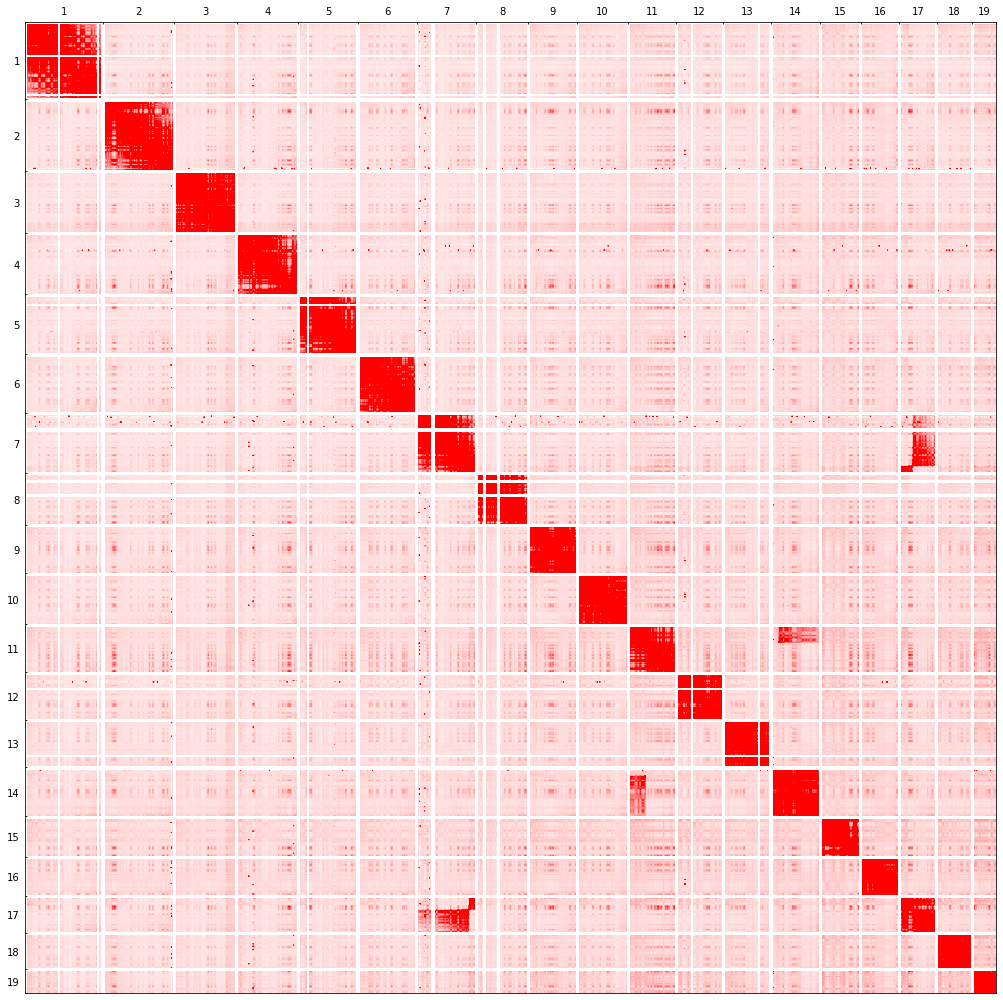

In [17]:
# plotting whole contact matrix
fig2, ax2 = plt.subplots()

ax, im = plotmatrix(normgw * scale, redmap, vmax = 15, ax = ax2, 
                    xticks = indarr, yticks = indarr,
                    xchroms = [str(i) for i in range(1, 20)],
                    ychroms = [str(i) for i in range(1, 20)])

fig2.set_figheight(14)
fig2.set_figwidth(14)
fig2.tight_layout()
fig2.savefig('genomewideHiCmap.pdf')

## Finding optimal number of clusters
Revisiting the way HMMs work, we stumble across another important question: 

If HMMs try to learn the most likely sequence of a predefined number of states in a sequence of samples, how do we know how many states we are looking for? Or put better: What is the number of states that fits the data best?

This is essentially the same question as with using k-Means or other clustering algorithms where we ask how many clusters are there in my data. 

In supervised learning (i.e. learning from labelled data as in regression of classification) we can simply apply a learning algorithm to the data and compare the labels assigned by the algorithm to the labels of the data given to determine the best model parameters. However, in unsupervised problems (i.e. we do not know the labels of the data in advance) we are confronted with the situation that we want to find patterns in a given data set upon which we can group them by similarity. 

However, although we unsupervised algorithms learn cluster assignments from scratch and we do not have the same opportunities to test the inferred model as in supervised settings, we can think of this problem as finding a model that best describes our data. Or put more simply, that recovers a maximum of information from the data set.
Luckily, there are two popular measures to assess the amount of information discovered in a dataset, the Akaike information criterion (AIC) and the Bayesian information criterion (BIC).

$$AIC = -2*log(\hat{\theta}) + 2*k$$

$$BIC = -2*log(\hat{\theta}) + 2*k*log(n)$$

where $log(\hat{\theta})$ describes the log-liklihood of the given data given the model (i.e. how likely is it that we find the observed data if the current model is the true generating model), $k$ is the number of parameters in the model and $n$ is the number of data points (i.e. rows in the matrix $\mathbf{C}$).

While both measures aim to find the best fitting model while controlling for overfitting (you can fit any type of data perfectly if your model just has enough parameters), the AIC tends to favor more complex models even for small datasets. Thus, the BIC is a more robust measure since it also accounts for the size of the data set. 

In a sense one can think of the BIC as a measure of how well the model fits the data with respect to the number of parameters and the size of the dataset. If we have a good fit the log-liklihood will be high, but if this goes at the expense of having a high number of parameters in comparison to the size of the data, the BIC will be high. If we have a bad fit but a small number of parameters as opposed to a high number of data points the BIC will also be high. Thus, we aim to find the minimum BIC over a given interval of parameters.

$$n = \{k \in [v, w]\ | \min_{k}{BIC(k)}\}$$

where $k$ is the number of clusters we want to find and $v$ and $w$ are the interval boundaries describing the range of values for $k$.

The number of parameters for a HMM with $k$ states and gaussian emission probabilities is given as follows:

A HMM is defined by a $k \times k$ matrix $\mathbf{P}$ holding the transition probabilities from state $i$ to state $j$. Since we have $\sum_{j = 1}^{k}{P_{i,j}} = 1$ for a given row $i$, each value in the row is determined if we already know the other $n - 1$ values of the row. Thus, the number of free parameters in the transition matrix is given by $k*(k-1)$. Furthermore, each state owns an emission probability for each data point (i.e. probability of observing the given data point in a given state), which in our case are governed by a multivariate gaussian distribution with diagonal covariance matrix. For each state, we thus have $n$ mean and $n$ variance parameters which gives us $2*n*k$ parameters to fit for each emission probability, which ultimately gives us:

$$AIC = -2*log(\hat{\theta}) + 2*(k*(k-1) + 2*k*n)$$

$$BIC = -2*log(\hat{\theta}) + 2*log(n)*(k*(k-1) + 2*k*n)$$

$log(\hat{\theta})$ is calculated from the fitted model using the Viterbi algorithm.

The plot below shows the AIC and BIC as calculated for values of $k = 1 \dots 15$. While the AIC exhibits a minimum at $k = 13$ (due to the reasons outlined above) BIC shows a slight minimum at $k = 8$. However, when looking at the results for $k = 3 \dots 8$, $k = 5$ gives the best visual contrast between rows exhibiting the same z-score pattern, which is in line with the findings of Rao et al. Thus, all further analysis were done with $k = 5$.

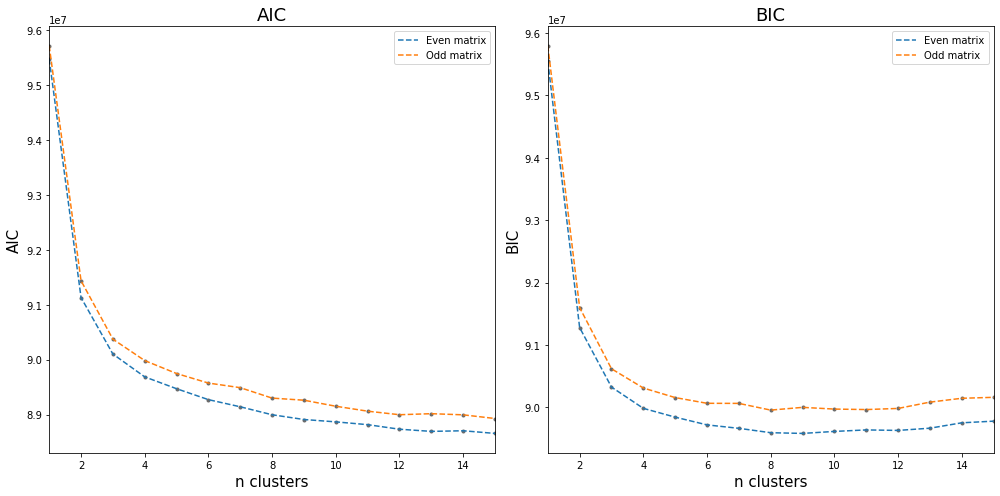

In [18]:
# plotting AIC BIC
fig1, axs1 = plt.subplots(1, 2)

# reading AIC/BIC results from file
# this is due to the long runtime of the procedure
# computation is done with the commented function below
resnpz = np.load('cluster/CH12_HiC_200kb_KR_cluster.npz')
ICdict = {''.join(k): resnpz[''.join(k)] for k in it.product(['even', 'odd'], ['AIC', 'BIC'])}

for criterion, ax in zip(['AIC', 'BIC'], axs1):
    #ax = plotInformationCriterion(clustmats['even'], clustmats['odd'], 
    #                              ax, componentrange = (1, 15),
    #                              criterion = criterio)
    for ICarr, label in zip([ICdict['even' + criterion], ICdict['odd' + criterion]], 
                            ['Even matrix', 'Odd matrix']):
          
        ax.plot(np.arange(1, len(ICarr) + 1), ICarr, label = label, ls = '--', zorder = 1)
        ax.scatter(np.arange(1, len(ICarr) + 1), ICarr, marker = '.', color = 'dimgrey')

    ax.set_ylabel(criterion, fontsize = 15)
    ax.set_xlabel('n clusters', fontsize = 15)
    ax.legend()
    ax.set_title(criterion, fontsize = 18)
    ax.set_xlim(1, 15)
    
fig1.set_figwidth(14)
fig1.set_figheight(7)
fig1.tight_layout()
fig1.savefig('informationCriterion.pdf')

## Results of clustering along odd chromosomes
The figure below shows the clustering results of performing the above outlined approach with $k = 5$ for the transformed $\mathbf{C_{i,j}}$ of the odd chromosomes. Odd chromosome bins reside on the y-axis, bins of even chromosomes on the x-axis. The left plot shows the original transformed matrix, the right plot displays the same matrix colored for the different inferred clusters. One can see a that visually distinct patterns in the original matrix appear in the same color after clustering suggesting a good fit of the model.

In [19]:
# reading clustering result for k = 5 for even and odd clustering
# from result file
clusters = {k: resnpz[k + 'k5'] for k in ['even', 'odd']}

# size of normgw without chrX
gwmatdim = normgw.shape[0]

# initialize chromosome names
chroms = {'evenchroms': [str(i) for i in range(2, 20, 2)],
          'oddchroms': [str(i) for i in range(1, 20, 2)]}

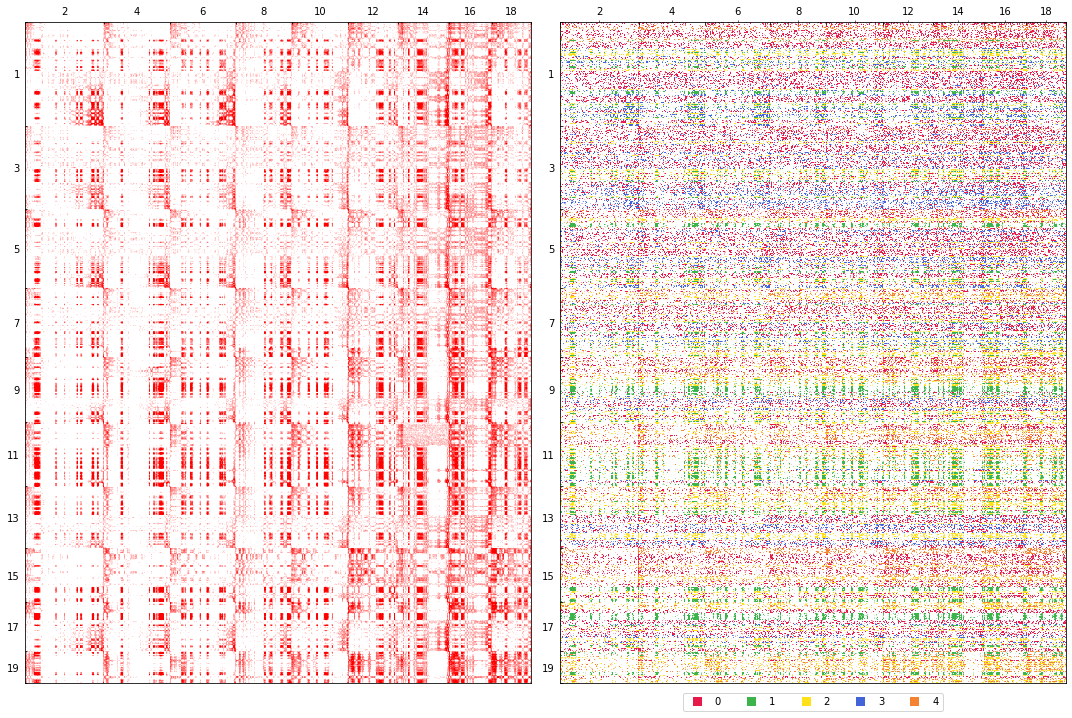

In [20]:
# plotting clustering of odd chromosomes
key = 'odd'
# visualize odd results in contrast to original matrix
fig3, axs3 = plt.subplots(1, 2)
xchroms, ychroms = chroms['evenchroms'], chroms['oddchroms']
        
yinds, xinds, shape = updateindex(indarr, gwmatdim, chrlist, 
                                  remrows[key], remcols[key])

ax1, im = plotmatrix(clustmats[key], redmap, vmax = 1, xticks = xinds, 
                     yticks = yinds, ax = axs3[0], 
                     xchroms = xchroms, ychroms = ychroms, aspect = 'auto')

ax2, meshes = plotClustering(clustmats[key], clusters[key], axs3[1],
                             ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231'],
                             xticks = xinds, yticks = yinds, xchroms = xchroms, 
                             ychroms = ychroms, vmin = 0.5, vmax = 1)

fig3.set_figwidth(15)
fig3.set_figheight(10)
fig3.tight_layout()
fig3.savefig('oddclustering.pdf')

## Results of clustering along even chromosomes
The same result is obtained from clustering the transformed $\mathbf{C_{i,j}}$ for even chromosomes.

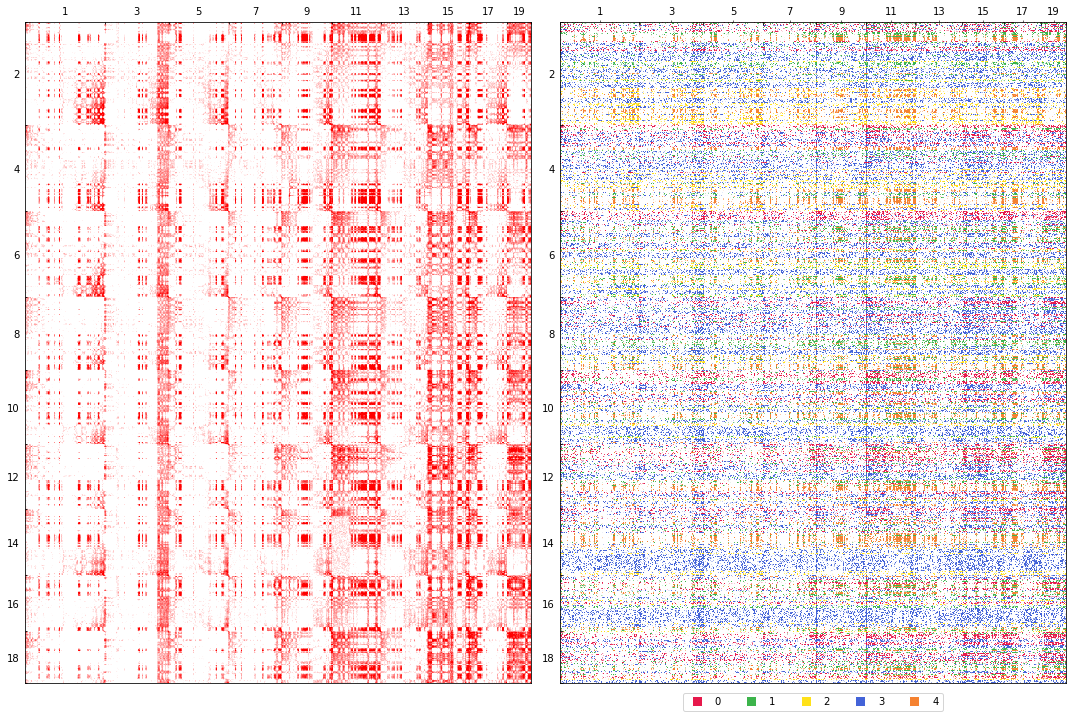

In [21]:
# plotting clustering of even chromosomes
key = 'even'
# visualize even results in contrast to original matrix
fig4, axs4 = plt.subplots(1, 2)

ychroms, xchroms = chroms['evenchroms'], chroms['oddchroms']
        
yinds, xinds, shape = updateindex(indarr, gwmatdim, chrlist, 
                                  remrows[key], remcols[key], even = True)

ax1, im = plotmatrix(clustmats[key], redmap, vmax = 1, xticks = xinds, 
                     yticks = yinds, ax = axs4[0], 
                     xchroms = xchroms, ychroms = ychroms, aspect = 'auto')
        
ax2, meshes = plotClustering(clustmats[key], clusters[key], axs4[1],
                             ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231'],
                             xticks = xinds, yticks = yinds, xchroms = xchroms, 
                             ychroms = ychroms, vmin = 0.5, vmax = 1)

fig4.set_figwidth(15)
fig4.set_figheight(10)
fig4.tight_layout()
fig4.savefig('evenclustering.pdf')

## Inferring assignment of clusters to A or B compartments by correlation
In order to find a hint of correspondence between our clusters aka subcompartments and the compartmentalization computed as the first eigenvector of the O/E matrix we compute the spearman correlation between the clusters and the eigenvector values for the given assignments. This is done by first resolving the actual genomic location the clusterassignment corresponds to (i.e. putting back removed bins) and then computing the Spearman correlation coefficient between the eigenvector values for even or odd chromosomes and special clustertracks in which bins of the currently examined cluster are assigned 1 and all others are assigned -1. In this way we compute a Spearman correlation coefficient for each cluster on even and odd chromosomes. In the we usually assign every cluster with positive correlation to A compartments and every cluster with negative correlation to B compartments

In [34]:
#computing expected
transform = {'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']}
c = cooler.Cooler(cooler_file)
regions = [(chrom, 0, c.chromsizes[chrom]) for chrom in c.chromnames]
cis_exp = compute_cis_expected(c, regions, weight_name = 'weight', transform = transform)

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: 

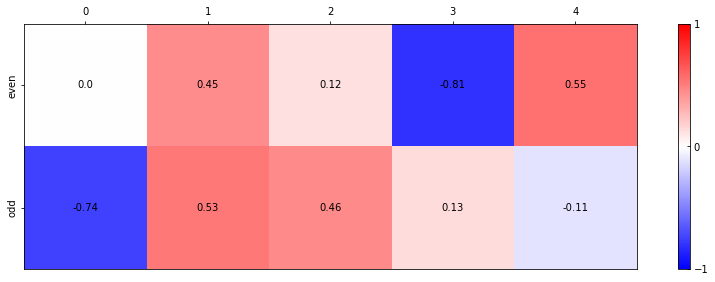

In [43]:
oefetcher = make_cis_obsexp_fetcher(c, (cis_exp, 'balanced.avg'), 'weight')
chrlens = readchromlens('mm9.chrom.sizes')
regionsdict = {chrom: (chrom, 0, c.chromsizes[chrom]) for chrom in c.chromnames}
eigvtrackperchr = getGenomewideEigv(oefetcher, chrlist, regionsdict, 'mm9_refseq.merged.bed', 200000)
# constructing indices to access index array per chromosome
#eigvtrackperchr = getGenomewideEigv(mat, chrlist, 'mm9_refseq.merged.bed', 200000, indarr)
evenpair, oddpair = [(['chr' + str(i) for i in range(i, 2*k + i, 2)], 
                      [[i, i + 1] for i in range(k)]) for k, i in zip((9, 10), (2, 1))]

evenchroms = {k: i for k, i in zip(*evenpair)}
oddchroms = {k: i for k, i in zip(*oddpair)}

correlationAB = np.zeros(shape = (2, 5))
for i, clustering, clusterchrs in zip([0, 1], ['even', 'odd'], [evenpair[0], oddpair[0]]):
    rowinds, colinds, (nr, nc) = updateindex(indarr, gwmatdim, chrlist, 
                                             remrows[clustering], remcols[clustering], 
                                             even = True if clustering == 'even' else False, 
                                             return_original = True)
    
    clustertrack = np.empty(shape = 0, dtype = int)
    eigtrack = np.empty(shape = 0, dtype = int)
    for chr in clusterchrs:
        start, stop = evenchroms[chr] if clustering == 'even' else oddchroms[chr]

        binassigns = getBinAssignments(nr, clusters[clustering], 
                                       startbin = rowinds[start], 
                                       stopbin = rowinds[stop] if stop != len(rowinds) else nr, 
                                       rembins = remrows[clustering])
        clustertrack = np.concatenate([clustertrack, binassigns])
        eigtrack = np.concatenate([eigtrack, eigvtrackperchr[chr]])
    
    correlationAB[i, :], p = correlateSegmentationWithEigv(clustertrack, eigtrack, [0, 1, 2, 3, 4])
    
fig5, axs5 = plt.subplots()
plotheatmap(correlationAB, axs5, 'bwr', ['0', '1', '2', '3', '4'], 
            ['even', 'odd'], vmax = 1, vmin = -1, cbar = True, cbarticks = [1, 0, -1], reorder = False)

fig5.set_figwidth(12)
fig5.set_figheight(4)
fig5.tight_layout()

## Computing correlation between clusters
To find a correspondance between clusters on even and odd chromosomes we first compute the paiwise correlation between the two. To achieve this we first construct a matrix $\mathbf{C_{i,j}}$ for even and odd chromosomes from the genomewide KR-normalized contact matrix without transforming them and compute the first derivative matrix $\mathbf{D}$ of each row in $\mathbf{C}$ which is simply given by

$$d_{i,j} = C_{i,j+1} - C_{i,j}$$

where $j+1$ and $j$ are adjacent loci. Having computed the derivative matrix $\mathbf{D} = (d_{i,j})$, we then take the mean over all rows assigned to a given cluster $k$. These mean derivative vectors are then used to determine the Spearman correlation coefficient for each pair of clusters.

This approach has a simple explanation which is most figurative in the light of the definition of covariance/correlation. Covariance and Correlation are measures which reflect how much two random variable vary together. Thus, if we generate a difference vector for each bin over all interactions with other bins we expect $|C_{i,j+1} - C_{i, j}|$ to be close to 0 if the contacts between $i$ and $j$ and $i$ and $j+1$ are similar and high if these contacts exhibit a change (e.g. if bin $j$ is within a similar cluster and $j+1$ is in another). Therefore, if we look at the correlation of these changes in each cluster we can assess if a given pair of clusters has similar interaction changes or not.

There are many types of correlation coefficients of which Pearson and Spearman correlation coefficients are the most simple and popular ones. While the Pearson correlation inherently assumes normally distributed random variables, the Spearman correlation does not. Since counts along a genome either follow a Poisson or negative binomial distribution. The Spearman correlation is the weapon of choice and is computed as follows:

For a given non-normally distributed pair of random variables $X$ and $Y$ the Spearman correlation coefficient $r_{S}$ is given as

$$r_{S} = \frac{Cov(rg_{X}, rg_{Y})}{\sigma_{rg_{X}}\sigma_{rg_{Y}}}$$

where $rg_{X}$ and $rg_{Y}$ are rank-transformations of $X$ and $Y$, $Cov(rg_{X}, rg_{Y})$ is the covariance between the rank-transformed variables and $\sigma_{rg_{X}}$ and $\sigma_{rg_{Y}}$ are the standard deviations of rank-transformed variables. The rank-transformation is done by simply sorting observations in $X$ ascendingly, assign ranks from 1 to |observations| and doing the same for $Y$. Since $X$ and $Y$ are paired observations (i.e. we always observe $X$ and $Y$ together, in our case two bins with the same index but different clusters) we can compare the ranks of each pair and compute the Spearman correlation. Intuitively, the $r_{S}$ will be high if observations in $X$ have similar ranks as observations in $Y$ and low if the opposite is true.

Projected on our scenario we will have a high Spearman correlation if the rank of a bin $j$ in cluster $k$ is similar to the rank of the same bin in another cluster, hence if the bins in cluster $k$ have similar values for $d_{i,j}$ as in another cluster.

The figure below shows the results, where the mean derivative vectors for each cluster were ordered using a single link hierarchical clustering (i.e. two vectors exhibiting a minimum distance are clustered determining the order) previous to correlation computation (this does not interfere with the computation but just makes sure clusters are ordered accordingly and 1.0 values are on the diagonal of the resulting correlation matrix).

While not as perfect as shown by Rao et al. (probably due to the lower resolution) one can observe clusters of correlation between A1, A2, A3 and B1 and B2.

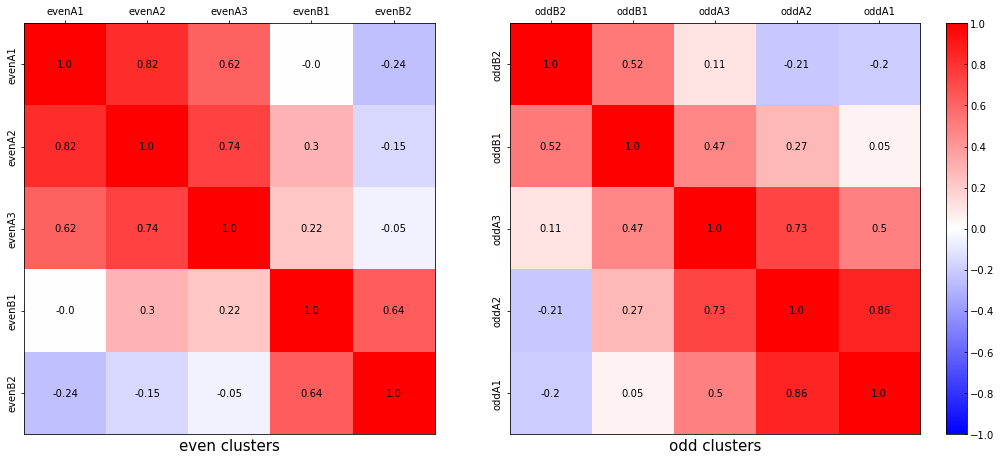

In [44]:
# compute cluster correlation
fig6, axs6 = plt.subplots(1, 2)
corrmat = None

# mapping labels to clusters
labels = {}
subcompartmentnames = np.array(['A1', 'A2', 'A3', 'B1', 'B2'])
for i, clustering in enumerate(['even', 'odd']):
    tmplabels = np.array([clustering + sbn for sbn in subcompartmentnames])
    corrorder = np.argsort(correlationAB[i, :])[::-1]
    assigned = list(tmplabels)
    for idx, label in zip(corrorder, tmplabels):
        assigned[idx] = label
    
    labels[clustering] = assigned

for (key, mat), ax, cbar in zip(orimats.items(), axs6, [False, True]):
    ax, corrmat = correlateClusters(mat, clusters[key], ax = ax, cmap = 'bwr', 
                                    txtclr = 'black', labels = labels[key], cbar = cbar)
    ax.set_xlabel('even clusters' if key == 'even' else 'odd clusters', fontsize = 15)
    
fig6.set_figheight(6.5)
fig6.set_figwidth(15)
fig6.tight_layout()
fig6.savefig('clustercorrelation.pdf')

## Computation of preferential cluster interaction
To assess the preferential interaction between cluster and therefore a mapping between even and odd chromosome clusters, we computed the enrichment in interaction between a pair of described clusters. 

To do so we first construct a matrix $\mathbf{C_{i,j}}$ from a interchromosomal KR normalized genomewide contact matrix. This is done by simply constructing the raw genomewide contact matrix without the intrachromosomal matrices, performing KR-normalization on this matrix and then construct $\mathbf{C_{i,j}}$ as described before. 
The rationale behind this approach is to remove count biases which might be introduced by normalizing with the intrachromosomal contact matrices, since these exhibit much higher contacts due to the nature of their linear polymer.

We then compute the mean observed number between a pair of clusters by summing over all bins assigned to a given cluster $k$ on the odd chromosomes, interacting with bins of a another cluster $p$ on the even chromosomes and taking the mean. This value is then divided by the number of expected contacts between a pair of clusters computed from 100 shuffled cluster assignments (i.e. shuffling clusterassignments on even and odd chromosomes and computing mean contact value as before).

The figure below shows the results for this analysis indicating a one-to-one mapping between the clusters (although again not perfect due to lower resolution)

In [45]:
# compute and plot interaction preferences
cijnpz = np.load('CH12_HiC_200kb_interKR.npz')
interCij, interinds, interchrs = cijnpz['cij'], cijnpz['inds'], cijnpz['chrlist']
# removing rows and cols as before
removelim = 0.3

# computing fractions of 0 elements in rows
rowzerofrac = 1 - np.count_nonzero(interCij, axis = 1)/interCij.shape[1]
colzerofrac = 1 - np.count_nonzero(interCij, axis = 0)/interCij.shape[0]

# finding indices of rows and removing them
rowrembins = np.where(rowzerofrac > removelim)[0]
rowrembins.sort()

boolrowrembins = rowzerofrac > removelim
interCij = interCij[~boolrowrembins, :]

# same for columns
colrembins = np.where(colzerofrac > removelim)[0]
boolcolrembins = colzerofrac > removelim
interCij = interCij[:, ~boolcolrembins]

# checking if removed rows and cols are the same as before
#print('removed rows are the same: ', np.all(rowrembins == remrows['odd']))
#print('removed columns are the same: ', np.all(colrembins == remcols['odd']))

interactions, observed, expected = analyseClusterInteraction(interCij, clusters)

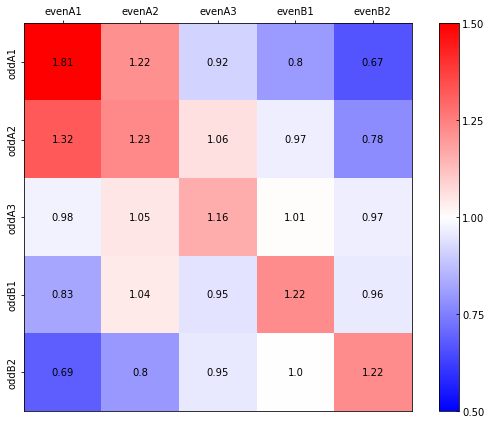

In [46]:
# plotting interaction preference
fig6, ax6 = plt.subplots()
plotheatmap(interactions, ax6, 'bwr', labels['even'], labels['odd'], cbarticks = [0.5, 0.75, 1, 1.25, 1.5])

fig6.set_figheight(6)
fig6.set_figwidth(8)
fig6.tight_layout()
fig6.savefig('clusterinteraction.pdf')

## Computing genome coverage and mean size of clusters
After generating a mapping between clusters we finally are able to compute the genomic coverage of each cluster and the mean and median clustersize. The figure below shows the results of this, where the left plot shows the coverage of each cluster in million basepairs and the right plot gives the mean size of each cluster in kilobasepairs (the black line in each bar indicates the median size).

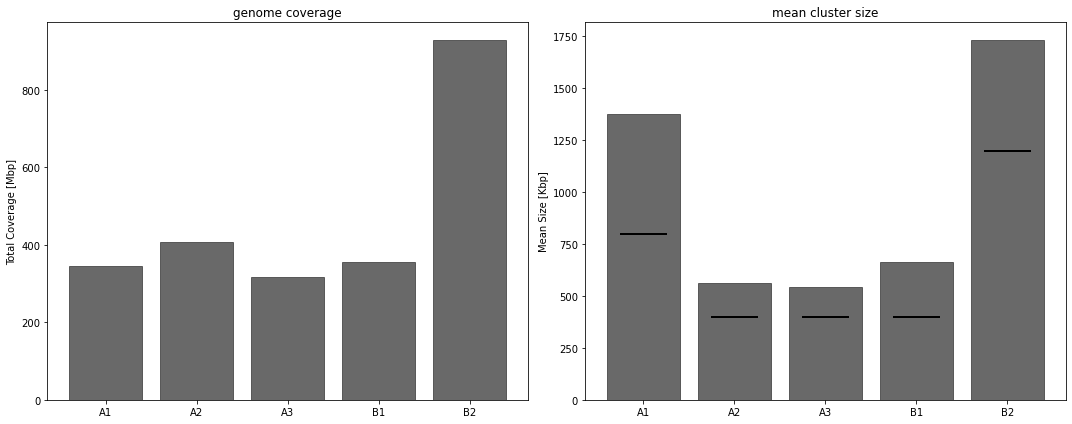

In [49]:
# plotting genome coverage and mean clustersize
# generating map of odd to even clusters
evenlabels = np.array([k[4:] for k in labels['even']])
odd2even = {odd: even for odd, even in 
                      zip(range(5), [np.where(evenlabels == l[3:])[0][0] for l in labels['odd']])}

fig7, axs7 = plt.subplots(1, 2)
for ax, title, plotfunc in zip(axs7, 
                               ['genome coverage', 'mean cluster size'], 
                               [clusterCoverage, meanClusterSize]):
    plotfunc(clusters, odd2even, 200000, ax, [l[3:] for l in labels['odd']])
    ax.set_title(title)
    
fig7.set_figwidth(15)
fig7.set_figheight(6)
fig7.tight_layout()
fig7.savefig('clustercoverageandsize.pdf')

## Coverage of clusters per chromosome
The same coverage analysis can be done per chromosome. The plot below shows the percentage bins of a given chromosome assigned to a given cluster. UD referes to chromosome bins that were removed from the analysis due to sparsity.

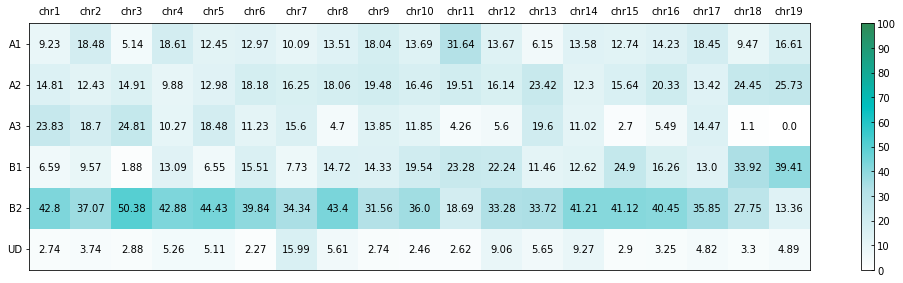

In [51]:
# plotting cluster coverage per chromosome
fig8, ax8 = plt.subplots()

# adding undefined binindex to clustermap
odd2even.update({-1: -1})
wbg = clr.LinearSegmentedColormap.from_list('wbg', ['White', 'powderblue', 'c', 'seagreen'], N = 256)
chromosomeSubcompartments(indarr, gwmatdim, chrlist, 
                          remrows, remcols, clusters, odd2even, 
                          ax8, [l[3:] for l in labels['odd']], cmap = wbg)

fig8.set_figwidth(15)
fig8.set_figheight(4)
fig8.tight_layout()
fig8.savefig('chromosomeclustercoverage.pdf')

## Enrichment and Correlation of signal tracks and clusters
The last step of this analysis is the computation of enrichment of and correlation with a given signal from the sequence data available to us. This includes all histone marks, transcription factors as well as DNAse hypersensitivity and SNS-Seq data.

We first divided the genome in 250 kbp bins and counted the number of non-duplicate reads for each signal track in each bin.

The enrichment was then calculated by dividing the median value of number of reads in each bin belonging to a given cluster by the genomewide median value.

The Spearman correlation was computed against a pseudo cluster track where all bins along the genome not belonging to a given cluster have the value -1 and all bins belonging to the given cluster have a value of 1. This approach is again based on the definition of the correlation coefficient, where correlation will be high if the signal is high in bins belonging to a cluster with respect to all other bins and low if vice-versa.

The figure below shows the results as heatmaps. The top heatmap displays the signal enrichment per cluster and signaltrack. The bottom heatmap shows the Spearman correlation of the each cluster with a given signaltrack (value in parentheses is the corresponding p-value).

Looking at this we see that B1 and B2 both exhibt anti-correlation with and depletion with all signaltracks that would define open chromatin. In addition B2 shows strong enrichment and correlation with the classic closed chromatin mark H3K09me3 and also strongly correlates with late replicating genomic areas.

Suprisingly, we also have slight enrichment and correlation with the KD SNS-Seq tracks of the unstimulated condition, while the WT correlates with the open chromatin states. This suggest, that there is a shift from open chromatin to highly condensed chromatin in the B2 subcompartment

In [58]:
# generating clustertrack and reading signaltracks
# reversing odd2even to even2odd
even2odd = {v: k for k, v in odd2even.items()}
clustertrack, int2stringmap = generateClusterTrack(indarr, gwmatdim, chrlist, 
                                                   remrows, remcols, clusters, even2odd, 
                                                   [l[3:] for l in labels['odd']])

chrbins = {}
for i, chr in enumerate(chrlist):
    chrbins[chr] = indarr[i + 1] - indarr[i] \
        if i + 1 != len(indarr) else gwmatdim - indarr[i]

# available signaltracks
tracks = {'usLacZ': 'CH12_unstimulated_shLacZ_200000.bdg',
          'usMcm6': 'CH12_unstimulated_shMcm6_200000.bdg',
          'dhs': 'dhs_200000.bdg', 'h3k04me1': 'h3k04me1_200000.bdg', 
          'h3k04me3': 'h3k04me3_200000.bdg',
          'h3k09me3_WT': 'h3k09me3_WT_200000.bdg',
          'h3k09me3_KD': 'h3k09me3_KD_200000.bdg',
          'h3k27ac': 'h3k27ac_200000.bdg', 'h3k27me3': 'h3k27me3_200000.bdg', 
          'h3k36me3': 'h3k36me3_200000.bdg', 'Repliseq_WT_E': 'repliseq_WT_E_200000.bdg',
          'Repliseq_WT_L': 'repliseq_WT_L_200000.bdg'
}

signaltracks = {k: readSignalTrack(os.path.join('signals', file), 
                                   200000, chrbins, chrlist) for k, file in tracks.items()}

In [59]:
# computing enrichment and correlation
enrichment = np.zeros(shape = (len(tracks), len(np.unique(clusters['odd']))))
correlation = np.zeros(shape = (len(signaltracks), len(np.unique(clusters['odd']))))
corrpvals = np.zeros(shape = (len(signaltracks), len(np.unique(clusters['odd']))))
enrichlabels, correlatelabels = [], []

for i, (name, track) in enumerate(signaltracks.items()):
    if not name in {'RCearly', 'RClate', 'transHot'}:
        enrichment[i, :] = enrichSignal(track, clustertrack)
        enrichlabels.append(name)
    
    correlation[i, :], corrpvals[i, :] = correlateSignal(track, clustertrack)
    correlatelabels.append(name)

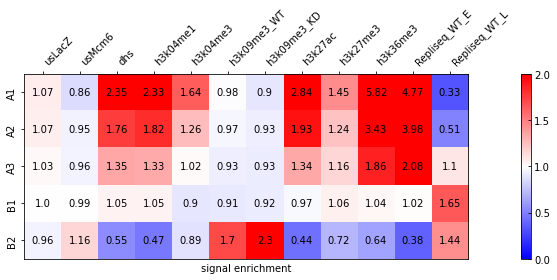

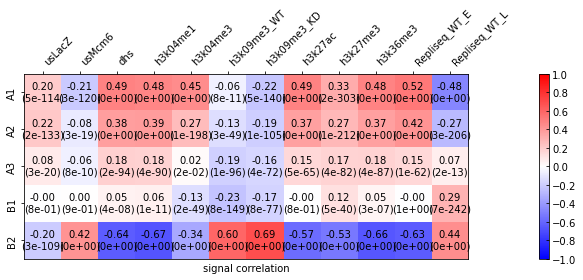

In [60]:
# plotting heatmaps
# sorting labels and matrices
ylabels = [l[3:] for l in labels['odd']]
sortinds = np.argsort(ylabels)
ylabels.sort()
sortenrichment = enrichment[:, sortinds]
sortcorrelation = correlation[:, sortinds]
sortcorrpvals = corrpvals[:, sortinds]

fig9, ax9 = plt.subplots()
plotheatmap(sortenrichment.T, ax9, 'bwr', enrichlabels, ylabels, vmin = 0, 
            vmax = 2, reorder = False, cbar = True, cbarticks = [0, 0.5, 1, 1.5, 2], xrotation = 45)
ax9.set_xlabel('signal enrichment')
fig9.set_figwidth(15)
fig9.set_figheight(4)
fig9.tight_layout()
fig9.savefig('signalenrichment_inhouseH3K09WT.pdf')

fig10, ax10 = plt.subplots()
plotheatmap(sortcorrelation.T, ax10, 'bwr', correlatelabels, ylabels, vmin = -1, 
            vmax = 1, reorder = False, cbar = True, 
            cbarticks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0], 
            pvals = sortcorrpvals.T, xrotation = 45)
ax10.set_xlabel('signal correlation')
fig10.set_figwidth(20)
fig10.set_figheight(4)
fig10.tight_layout()
fig10.savefig('signalcorrelation_inhouseH3K09WT.pdf')

In [61]:
# writing subcompartments to bedfile
indarr = np.concatenate([indarr, np.array([gwmatdim])])
writeSubcompartmentsToBed('CH12_subcompartments.bed', clustertrack, [l[3:] for l in labels['odd']], 
                          200000, chrlens, chrlist, indarr)